# Exploratory Data Analysis

As a data scientist, I want to get the information about the types of workloads, images , containers, shapes, etc and their inter-relationships from the insight operator archive data-set. For this purpose, I would like to perform, EDA on the workload data from 4.8+ clusters collected from the [Insight Operator Archive](https://github.com/openshift/insights-operator/blob/master/docs/insights-archive-sample/config/workload_info.json).

Exploratory Data Analysis is the initial analysis that we perform on the data to understand the data. It is important because before we create models or perform operations on the data, we should know what the data is all about, what all features it consists of, how these features are related to each other, etc.

In this notebook, the workload data from the insight operator archive is merged with the mapped data from pyxis database and data from the telemetry. 

Containers, images and image streams are important concepts to understand when we set out to create and manage containerized software. An image holds a set of software that is ready to run, while a container is a running instance of the container image. An image stream provides a way of storing different versions of the same basic image. Those different versions are represented by different tags on the same image name. 

## Data Collection and Preprocessing

In [1]:
import io
import boto3
import pandas as pd
import warnings
import os
import seaborn as sns
import matplotlib.pyplot as plt
import missingno as msno
import requests
from bs4 import BeautifulSoup
from IPython.display import IFrame

from dotenv import load_dotenv, find_dotenv

In [2]:
%matplotlib inline
load_dotenv(find_dotenv())
warnings.filterwarnings("ignore")

pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)

In [3]:
# CEPH Bucket variables
s3_endpoint_url = os.getenv("S3_ENDPOINT")
s3_access_key = os.getenv("S3_ACCESS_KEY")
s3_secret_key = os.getenv("S3_SECRET_KEY")
s3_bucket = os.getenv("S3_BUCKET")

# s3 resource to communicate with storage
s3 = boto3.resource(
    "s3",
    endpoint_url=s3_endpoint_url,
    aws_access_key_id=s3_access_key,
    aws_secret_access_key=s3_secret_key,
)

# access the parquet file as an s3 object

obj1 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/date=2021-05-12/2021-05-12.parquet"
)
obj2 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/containers/date=2021-05-12/2021-05-12.parquet"
)
obj3 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/dataframe_image_id.parquet"
)
obj4 = s3.Object("DH-PLAYPEN", "ccx/fingerprinting/containers/df_cont_image_id.parquet")
obj5 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/telemeter_image_data.parquet"
)
obj6 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/containers/telemeter_cont_data.parquet"
)

obj7 = s3.Object(
    "DH-PLAYPEN", "ccx/fingerprinting/image_layers/df_image_layerid.parquet"
)
# download the file into the buffer
buffer1 = io.BytesIO()
obj1.download_fileobj(buffer1)
buffer2 = io.BytesIO()
obj2.download_fileobj(buffer2)
buffer3 = io.BytesIO()
obj3.download_fileobj(buffer3)
buffer4 = io.BytesIO()
obj4.download_fileobj(buffer4)
buffer5 = io.BytesIO()
obj5.download_fileobj(buffer5)
buffer6 = io.BytesIO()
obj6.download_fileobj(buffer6)
buffer7 = io.BytesIO()
obj7.download_fileobj(buffer7)

# read the buffer and create the dataframe
image_layers_df = pd.read_parquet(buffer1)
image_id_map = pd.read_parquet(buffer3)
image_layer_idmap = pd.read_parquet(buffer7)
containers_df = pd.read_parquet(buffer2)
cont_id_map = pd.read_parquet(buffer4)
telemeter_image_data = pd.read_parquet(buffer5)
telemeter_cont_data = pd.read_parquet(buffer6)


In the above cell, we have fetched the following seven kinds of datasets from the bucket.

- Dataset with Image Layer information (image_layers_df)

- Dataset with Pyxis metadata for the image SHAs in the image_id column of above image layer dataset (image_id_map)

- Dataset with Pyxis metadata for the image SHAs in the layer_image_id column of above image layer dataset (image_layer_idmap)


- Dataset with Containers information (containers_df)
- Dataset with Pyxis metadata for the image SHAs in the image_id column of above container dataset (cont_id_map)


- Telemetry data corresponding to the cluster_ids in the image_layers_dataset (telemeter_image_data)
- Telemetry data corresponding to the cluster_ids in the containers dataset (telemeter_cont_data)

## Image Layer Dataset

The dataset which gives information about the images. 

In [4]:
image_layers_df.head(2)

,cluster_id,image_id,layer_image_id,layer_image_level,first_command,first_arg,archive_path
0,00003d61-9db1-4757-9cd1-84df271daeb9,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,sha256:9ebb302e1fb002fb643091710dac46f8258781d...,0,icTsn2s_EIax,2v1NneeWoS_9,archives/compressed/00/00003d61-9db1-4757-9cd1...
1,00003d61-9db1-4757-9cd1-84df271daeb9,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,sha256:a74396a32e85c2feeedf76052ed3297859810c8...,1,icTsn2s_EIax,2v1NneeWoS_9,archives/compressed/00/00003d61-9db1-4757-9cd1...


**Pyxis data for the image SHA’s in IMAGE_ID column of image_layers dataset** [Pyxis mapping notebook](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/blob/master/notebooks/pyxis_mapping.ipynb), [Issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/11#issuecomment-867776402)

We were able to map 111 (~44%) sha's of the image_id out of 256 sha's provided in the image layer dataset.

In [5]:
image_id_map = image_id_map.reset_index()
image_id_map.head(2)

,image_id,License,architecture,build-date,com.redhat.build-host,com.redhat.component,com.redhat.license_terms,description,distribution-scope,io.k8s.description,io.k8s.display-name,io.openshift.build.commit.id,io.openshift.build.commit.url,io.openshift.build.source-location,io.openshift.expose-services,io.openshift.maintainer.component,io.openshift.maintainer.product,io.openshift.tags,maintainer,name,release,summary,url,vcs-ref,vcs-type,vendor,version,io.openshift.s2i.scripts-url,io.s2i.scripts-url,usage,io.openshift.s2i.assemble-user,authoritative-source-url,io.fabric8.s2i.version.jolokia,org.concrt.version,org.jboss.product,org.jboss.product.amq.version,org.jboss.product.openjdk.version,org.jboss.product.version,com.redhat.deployments-dir,com.redhat.dev-mode,io.jenkins.version
0,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,GPLv2+,x86_64,2021-04-30T00:31:42.349887,cpt-1004.osbs.prod.upshift.rdu2.redhat.com,ose-cli-artifacts-container,https://www.redhat.com/agreements,"OpenShift is a platform for developing, buildi...",public,"OpenShift is a platform for developing, buildi...",OpenShift Clients,a765590e1b87b014b9d81f9ea534460d6dff73f2,https://github.com/openshift/oc/commit/a765590...,https://github.com/openshift/oc,,oc,OpenShift Container Platform,"openshift,cli","Red Hat, Inc.",openshift/ose-cli-artifacts,202104292348.p0,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,43f412b2932a5ecfe5ebedcab38cf2915cf03813,git,"Red Hat, Inc.",v4.8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,sha256:3574d6c1fcc46e1ebd41b7b887b92035ea18213...,GPLv2+,x86_64,2021-04-30T00:22:29.539443,cpt-1008.osbs.prod.upshift.rdu2.redhat.com,openshift-enterprise-cli-container,https://www.redhat.com/agreements,"OpenShift is a platform for developing, buildi...",public,"OpenShift is a platform for developing, buildi...",OpenShift Client,a765590e1b87b014b9d81f9ea534460d6dff73f2,https://github.com/openshift/oc/commit/a765590...,https://github.com/openshift/oc,,oc,OpenShift Container Platform,"openshift,cli","Red Hat, Inc.",openshift/ose-cli,202104292348.p0,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,d3ae20f4e2fac18ea671cf12636d16791146a460,git,"Red Hat, Inc.",v4.8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None


**Pyxis data for SHA’s in IMAGE_LAYER_ID column of image_layers dataset**

We were able to map 143 (~19%) sha's of the image_layer_id out of 752 sha's provided in the image layer dataset.

In [6]:
image_layer_idmap = image_layer_idmap.reset_index()
image_layer_idmap = image_layer_idmap.rename(columns={"image_id": "layer_image_id"})
image_layer_idmap.head(2)

,layer_image_id,architecture,build-date,com.redhat.build-host,com.redhat.component,com.redhat.license_terms,description,distribution-scope,io.k8s.description,io.k8s.display-name,io.openshift.expose-services,io.openshift.tags,maintainer,name,release,summary,url,vcs-ref,vcs-type,vendor,version,io.openshift.s2i.scripts-url,io.s2i.scripts-url,com.redhat.deployments-dir,com.redhat.dev-mode,com.redhat.dev-mode.port,help,usage,io.openshift.s2i.assemble-user,authoritative-source-url,License,Architecture,Authoritative_Registry,BZComponent,Build_Host,Name,Release,Vendor,Version,com.ibm.hdm.common.branch,com.ibm.hdm.common.buildnumber,com.ibm.hdm.common.commitId,org.label-schema.vcs-ref,org.label-schema.vcs-url,io.openshift.build.commit.id,io.openshift.build.commit.url,io.openshift.build.source-location,io.openshift.maintainer.product,io.openshift.maintainer.component,io.cekit.version,io.fabric8.s2i.version.jolokia,io.fabric8.s2i.version.maven,io.openshift.s2i.destination,org.jboss.container.deployments-dir,org.jboss.product,org.jboss.product.openjdk.version,org.jboss.product.version,org.concrt.version,org.jboss.product.amq.version,com.ibm.license_terms,org.label-schema.build-date,org.label-schema.license,org.label-schema.name,org.label-schema.schema-version,org.label-schema.vendor,io.fabric8.s2i.version.karaf,io.fabric8.s2i.version.prometheus.jmx_exporter,org.jboss.deployments-dir,org.jboss.product.eap.version
0,sha256:fdb393d8227cbe9756537d3f215a3098ae797bd...,x86_64,2021-02-10T00:15:26.710361,cpt-1004.osbs.prod.upshift.rdu2.redhat.com,ubi8-container,https://www.redhat.com/en/about/red-hat-end-us...,The Universal Base Image is designed and engin...,public,The Universal Base Image is designed and engin...,Red Hat Universal Base Image 8,,base rhel8,"Red Hat, Inc.",ubi8,289,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,7dd0869dabeebe7119fc04b16767c5991bcaa865,git,"Red Hat, Inc.",8.3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None
1,sha256:64607cc74f9cbe0e12f167547df0cf661de5a8b...,x86_64,2021-03-30T18:30:01.465792,cpt-1003.osbs.prod.upshift.rdu2.redhat.com,ubi8-container,https://www.redhat.com/en/about/red-hat-end-us...,The Universal Base Image is designed and engin...,public,The Universal Base Image is designed and engin...,Red Hat Universal Base Image 8,,base rhel8,"Red Hat, Inc.",ubi8,297,Provides the latest release of Red Hat Univers...,https://access.redhat.com/containers/#/registr...,7dd0869dabeebe7119fc04b16767c5991bcaa865,git,"Red Hat, Inc.",8.3,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None


**Telemetry dataset for the corresponding `CLUSTER_ID` from image_layers dataset**

In [7]:
telemeter_image_data.rename(columns={"_id": "cluster_id"}, inplace=True)
telemeter_image_data.head(2)

,cluster_id,timestamp,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum,value_openshift:cpu_usage_cores:sum,value_openshift:memory_usage_bytes:sum,value_cluster:cpu_usage_cores:sum,value_cluster:memory_usage_bytes:sum
0,00003d61-9db1-4757-9cd1-84df271daeb9,1620860062,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224
1,00351e6e-53ce-465e-9493-cf0cd2367049,1620852056,0.030943035959259964,385421312,1.7056283926121354,14386823168,1.7365714285713953,14772244480


## Containers Dataset

The datasets containing the information about the images running in the containers. 

In [8]:
containers_df.head(2)

,cluster_id,namespace,shape,shape_instances,image_id,first_command,first_arg,init_container,archive_path
0,00003d61-9db1-4757-9cd1-84df271daeb9,0LiT6ZNtbpYL,sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...,1,sha256:f46f210d6023bec16e68340b484a8881ce46d5e...,None,47DEQpj8HBSa,False,archives/compressed/00/00003d61-9db1-4757-9cd1...
1,00003d61-9db1-4757-9cd1-84df271daeb9,0LiT6ZNtbpYL,sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...,1,sha256:edb9aaacf421c6dc45b20324e8699cec02f26bf...,n9CdwzVF-cwZ,RNOaw_AuQeIY,False,archives/compressed/00/00003d61-9db1-4757-9cd1...


**Pyxis data for the image SHA’s in IMAGE_ID column of container dataset**

We were able to map 2478 (~45%) sha's of the image_id out of 5477 sha's provided in the container dataset.

In [9]:
cont_id_map = cont_id_map.reset_index()
cont_id_map.head(2)

,image_id,License,architecture,build-date,com.redhat.build-host,com.redhat.component,com.redhat.license_terms,description,distribution-scope,io.k8s.description,io.k8s.display-name,io.openshift.build.commit.id,io.openshift.build.commit.url,io.openshift.build.source-location,io.openshift.expose-services,io.openshift.maintainer.component,io.openshift.maintainer.product,io.openshift.tags,maintainer,name,release,summary,url,vcs-ref,vcs-type,vendor,version,io.openshift.maintainer.subcomponent,io.openshift.release.operator,io.openshift.build.versions,com.redhat.delivery.appregistry,upstream-vcs-ref,upstream-vcs-type,upstream-version,org.kubevirt.hco.csv-generator.v1,io.openshift.s2i.scripts-url,io.s2i.scripts-url,usage,io.openshift.s2i.assemble-user,display-name,com.redhat.delivery.operator.bundle,com.redhat.openshift.versions,io.cekit.version,operators.operatorframework.io.bundle.channel.default.v1,operators.operatorframework.io.bundle.channels.v1,operators.operatorframework.io.bundle.manifests.v1,operators.operatorframework.io.bundle.mediatype.v1,operators.operatorframework.io.bundle.metadata.v1,operators.operatorframework.io.bundle.package.v1,licenses,CEPH_POINT_RELEASE,GIT_BRANCH,GIT_CLEAN,GIT_COMMIT,GIT_REPO,RELEASE,ocs.tags,com.redhat.deployments-dir,com.redhat.dev-mode,com.redhat.dev-mode.port,help,operators.operatorframework.io.index.database.v1,authoritative-source-url,license,io.fabric8.s2i.version.jolokia,io.fabric8.s2i.version.maven,io.openshift.s2i.destination,org.jboss.container.deployments-dir,org.jboss.product,org.jboss.product.eap.version,org.jboss.product.openjdk.version,org.jboss.product.sso.version,org.jboss.product.version,istio_version,openshift_build,operator_build,run,org.concrt.version,org.jboss.product.amq.version,io.openshift.build.commit.author,io.openshift.build.commit.date,io.openshift.build.commit.message,io.openshift.build.commit.ref,io.openshift.build.name,io.openshift.build.namespace,io.openshift.build.source-context-dir,jenkins.build.number,jenkins.tarball.url,io.jenkins.version,build-utility,org.label-schema.vcs-ref,org.label-schema.vcs-url,org.label-schema.description,org.label-schema.license,org.label-schema.name,org.label-schema.schema-version,org.label-schema.vendor,JAVA_VERSION,com.ibm.events.commitid,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.commitid,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.job,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.license,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.maintainer,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.name,com.ibm.eventstreams.base-for-bedrock.icp-linux-amd64.version,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.commitid,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.job,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.license,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.maintainer,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.name,com.ibm.eventstreams.openjdk-11-sdk-for-bedrock.icp-linux-amd64.version,com.redhat.apb.runtime,com.microsoft.product,com.microsoft.version
0,sha256:f46f210d6023bec16e68340b484a8881ce46d5e...,ASL 2.0,x86_64,2021-05-04T21:54:58.392948,cpt-1007.osbs.prod.upshift.rdu2.redhat.com,kube-rbac-proxy-container,https://www.redhat.com/agreements,"This is a proxy, that can perform Kubernetes R...",public,"This is a proxy, that can perform Kubernetes R...",kube-rbac-proxy,8d11a8fa9ce252cd25794c0d9280cbdc0c2affcb,https://github.com/openshift/kube-rbac-proxy/c...,https://github.com/openshift/kube-rbac-proxy,,Monitoring,OpenShift Container Platform,kubernetes,OpenShift Monitoring Team <team-monitoring@red...,openshift/ose-kube-rbac-proxy,202105042126.p0,,https://access.redhat.com/containers/#/registr...,12ef9d3cc226f6bd4a898d4b23ffa1ec5d3d27f1,git,"Red Hat, Inc.",v4.8.0,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,None,Non

**Telemetry dataset for the corresponding `CLUSTER_ID` from containers dataset**

In [10]:
telemeter_cont_data.rename(columns={"_id": "cluster_id"}, inplace=True)
telemeter_cont_data.head(2)

,cluster_id,timestamp,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum,value_openshift:cpu_usage_cores:sum,value_openshift:memory_usage_bytes:sum,value_cluster:cpu_usage_cores:sum,value_cluster:memory_usage_bytes:sum
0,00003d61-9db1-4757-9cd1-84df271daeb9,1620860062,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224
1,00351e6e-53ce-465e-9493-cf0cd2367049,1620852056,0.030943035959259964,385421312,1.7056283926121354,14386823168,1.7365714285713953,14772244480


Using the mapping techniques from the [issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/14), we were able to map most (not all) of the image_id from the image layers dataset and containers datasets. Information from the telemetry dataset were also extracted ([issue](https://github.com/aicoe-aiops/openshift-workload-fingerprinting/issues/15)). In the next steps, we try to merge the respective dataset with respect to the `image_id` and `cluster_id`.

In the next section, we take the information about the _product name_ and _summary_ from the mapped dataset.

In [11]:
image_id_map = image_id_map[["image_id", "name", "summary"]]
cont_id_map = cont_id_map[["image_id", "name", "summary"]]

## Merging the datasets 

We do the `outer` merging in-order to keep all the information including those ids which were not mapped and those for which we could not extract any information from the telemeter dataset.

**Merged dataframe for image layers dataset**

We will be merging the workload dataset with Pyxis data on `image_id` column, and merging with the telemeter data on `cluster_id` column.

In [12]:
df_image1 = pd.merge(image_layers_df, image_id_map, on="image_id", how="outer")
df_image = pd.merge(df_image1, telemeter_image_data, on="cluster_id", how="outer")
df_image.head(2)

,cluster_id,image_id,layer_image_id,layer_image_level,first_command,first_arg,archive_path,name,summary,timestamp,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum,value_openshift:cpu_usage_cores:sum,value_openshift:memory_usage_bytes:sum,value_cluster:cpu_usage_cores:sum,value_cluster:memory_usage_bytes:sum
0,00003d61-9db1-4757-9cd1-84df271daeb9,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,sha256:9ebb302e1fb002fb643091710dac46f8258781d...,0,icTsn2s_EIax,2v1NneeWoS_9,archives/compressed/00/00003d61-9db1-4757-9cd1...,openshift/ose-cli-artifacts,Provides the latest release of Red Hat Univers...,1.620860e+09,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224
1,00003d61-9db1-4757-9cd1-84df271daeb9,sha256:337c22cabe530213b14965f9ea69a92dbeb5104...,sha256:a74396a32e85c2feeedf76052ed3297859810c8...,1,icTsn2s_EIax,2v1NneeWoS_9,archives/compressed/00/00003d61-9db1-4757-9cd1...,openshift/ose-cli-artifacts,Provides the latest release of Red Hat Univers...,1.620860e+09,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224


**Merged dataframe for containers dataset**

In [13]:
df_cont1 = pd.merge(containers_df, cont_id_map, on="image_id", how="outer")
df_cont = pd.merge(df_cont1, telemeter_image_data, on="cluster_id", how="outer")
df_cont.head(2)

,cluster_id,namespace,shape,shape_instances,image_id,first_command,first_arg,init_container,archive_path,name,summary,timestamp,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum,value_openshift:cpu_usage_cores:sum,value_openshift:memory_usage_bytes:sum,value_cluster:cpu_usage_cores:sum,value_cluster:memory_usage_bytes:sum
0,00003d61-9db1-4757-9cd1-84df271daeb9,0LiT6ZNtbpYL,sha256:3ecf29979b2722bf4a82a5e7a954e8685820720...,1,sha256:f46f210d6023bec16e68340b484a8881ce46d5e...,None,47DEQpj8HBSa,False,archives/compressed/00/00003d61-9db1-4757-9cd1...,openshift/ose-kube-rbac-proxy,,1.620860e+09,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224
1,00003d61-9db1-4757-9cd1-84df271daeb9,0LiT6ZNtbpYL,sha256:1e2788d7ec32815d3a0c2ded714ea4f57fc1c05...,1,sha256:f46f210d6023bec16e68340b484a8881ce46d5e...,None,47DEQpj8HBSa,False,archives/compressed/00/00003d61-9db1-4757-9cd1...,openshift/ose-kube-rbac-proxy,,1.620860e+09,0.03230751556666692,389971968,1.9291393691359602,14560608256,1.9614468847026272,14950580224


## Inspecting the Image Layers dataset

We have 17 different features in image_layers dataset. At first, we explored to see the distribution of first_Command, first_arg, name and summary in the dataset.

The different features in the dataset are listed below.

In [14]:
df_image.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 47368 entries, 0 to 47367
Data columns (total 16 columns):
 #   Column                                  Non-Null Count  Dtype  
---  ------                                  --------------  -----  
 0   cluster_id                              47368 non-null  object 
 1   image_id                                47368 non-null  object 
 2   layer_image_id                          47368 non-null  object 
 3   layer_image_level                       47368 non-null  int64  
 4   first_command                           34038 non-null  object 
 5   first_arg                               41209 non-null  object 
 6   archive_path                            47368 non-null  object 
 7   name                                    27524 non-null  object 
 8   summary                                 27524 non-null  object 
 9   timestamp                               45186 non-null  float64
 10  value_workload:cpu_usage_cores:sum      30771 non-null  ob

From the above info, we see that there are certain features which containes the missing values. To visualise the missing values in the dataset. We take the help of missingno packages. Some of the key points from the msno dataset are.

- Features like cluster_id, image_id, layer_image_id, layer_image_level, archive_path does not have any missing values.
- first_command and first argument have missing values.
- We could not map all the image_id from the Pyxis database, the results is clearly seen in the distribution of missing values in the dataset.
- Values extracted from the telemetry also have missing values because we could not extract the information from the telemetry for the given cluster_id from the insight operator archive.

<AxesSubplot:>

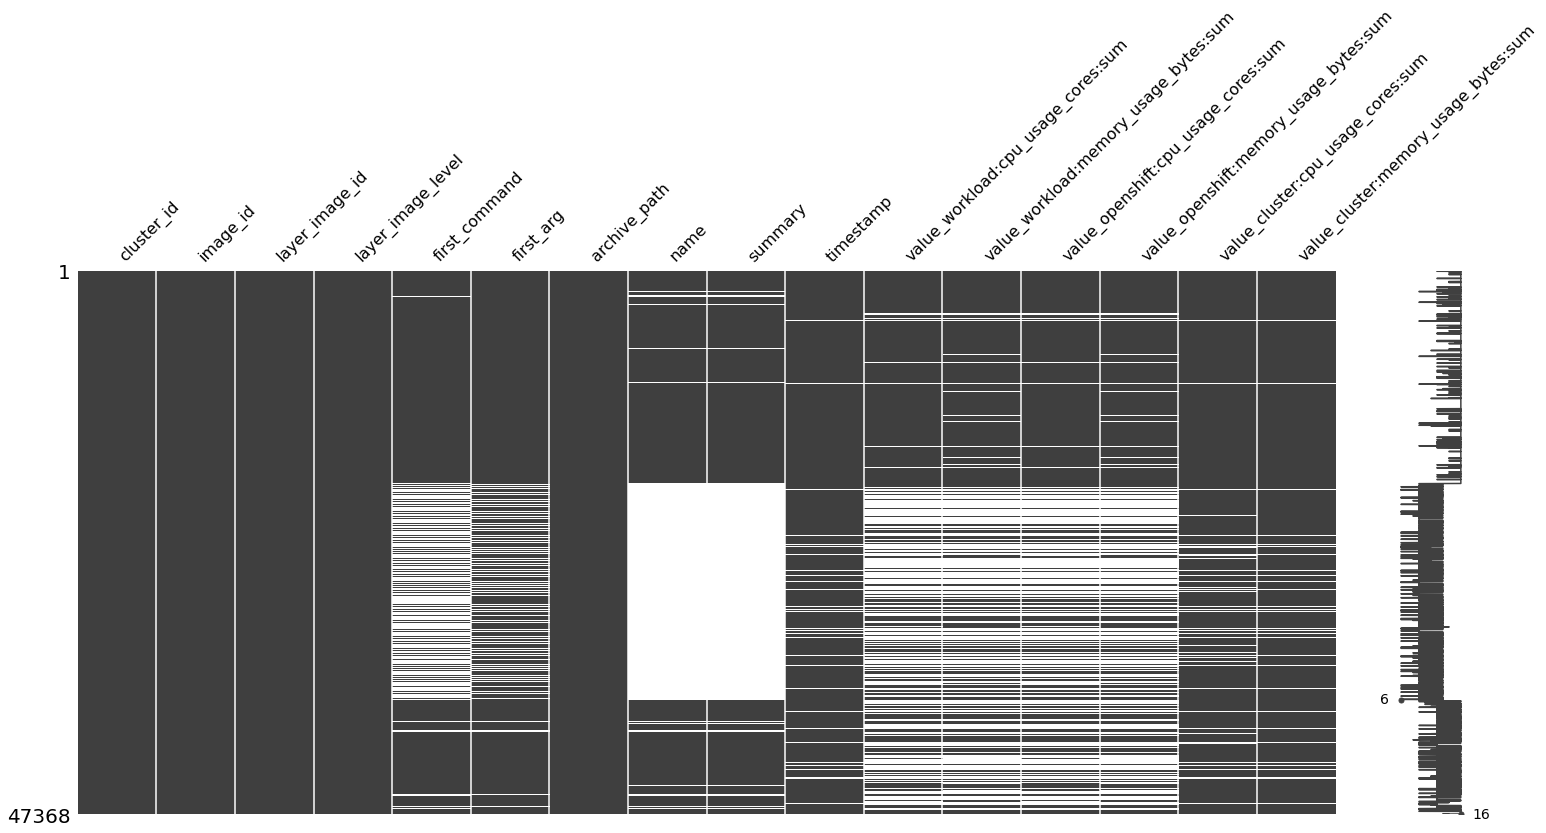

In [15]:
msno.matrix(df_image)

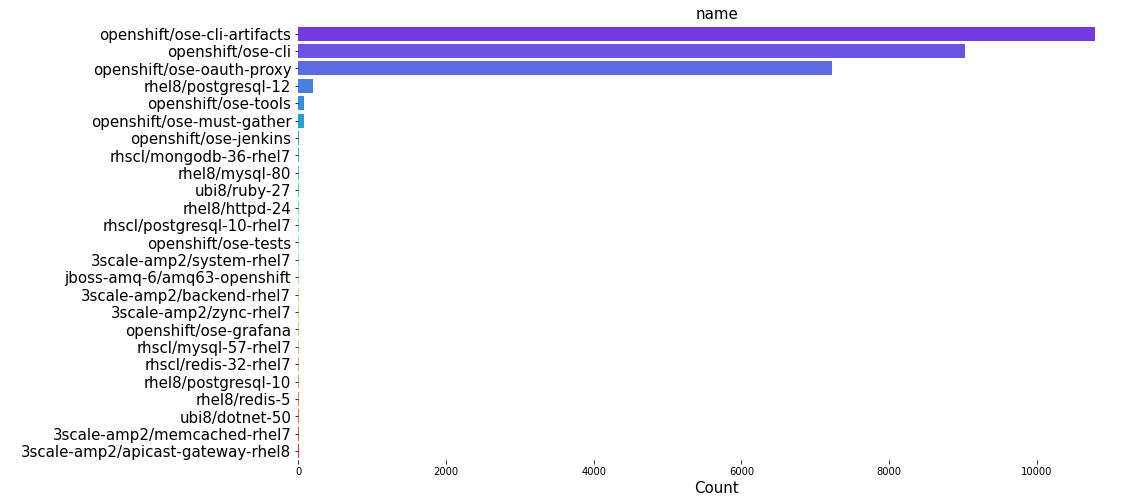

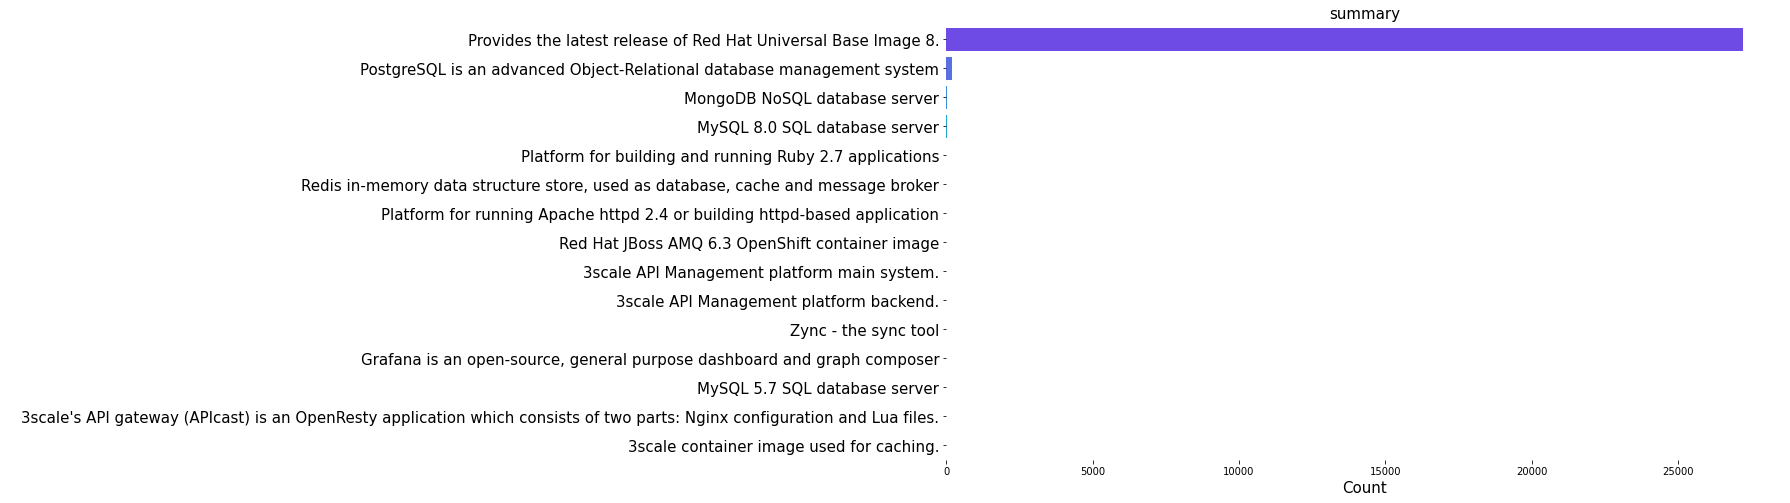

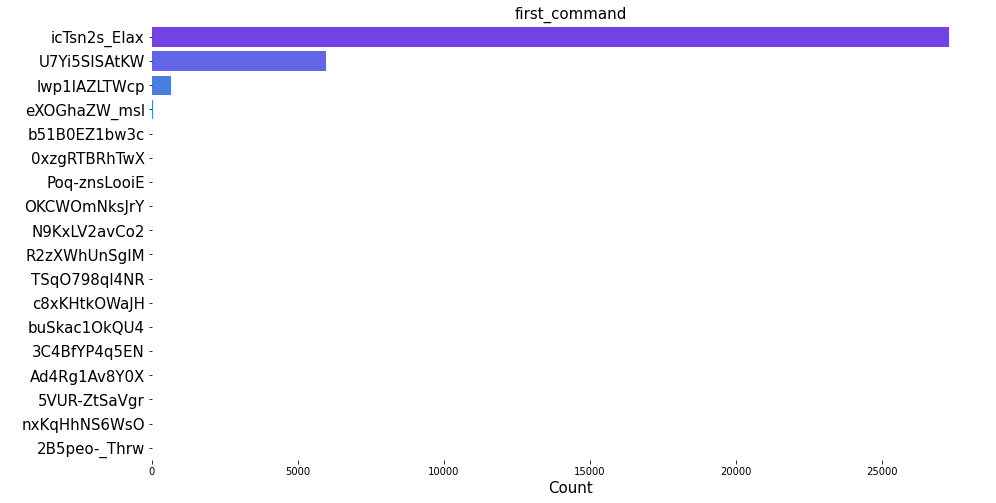

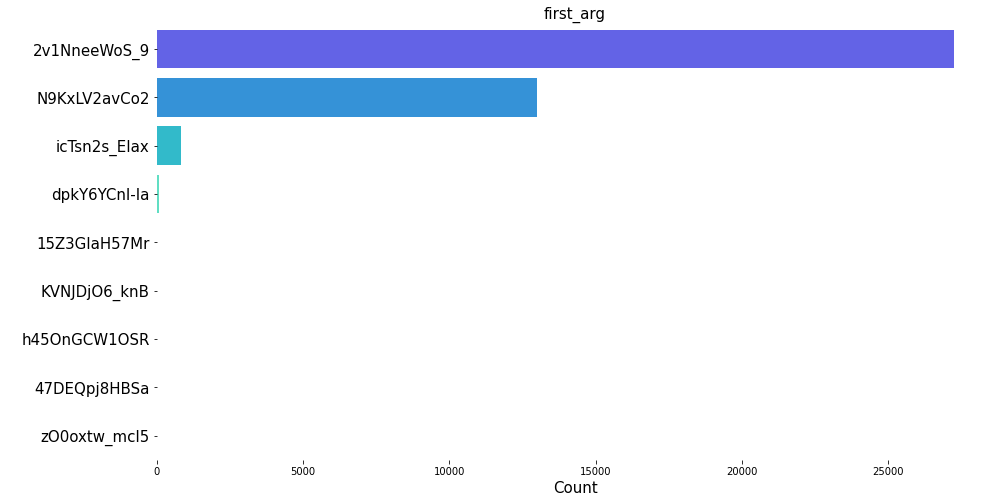

In [16]:
image_columns = ["name", "summary", "first_command", "first_arg"]

for col in image_columns:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    sns.countplot(
        y=df_image[col][1:],
        data=df_image.iloc[1:],
        order=df_image[col][1:].value_counts().iloc[:].index,
        palette="rainbow",
    )
    plt.title(col, fontsize=15)
    plt.xlabel("Count", fontsize=15)
    plt.ylabel(" ")
    plt.yticks(fontsize=15)
    plt.box(False)


The distribution plots for top 20 name, summary, first_command and first_arg shows that the image openshift/ose-cli-artifacts has the highest count of all. Similarly, from the summary, we can see that Red Hat UBI image has the maximum count. Furthermore, we can also see that certain commands and arguments are present in high amount in the image layers dataset.

## Inspecting the Containers dataset

We have 19 different features in container dataset. At first, we explored to see the distribution of `first_Command`, `first_arg`, `name` and `summary` in the dataset. 

Checking different features in the dataset,

In [17]:
df_cont.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 456825 entries, 0 to 456824
Data columns (total 18 columns):
 #   Column                                  Non-Null Count   Dtype  
---  ------                                  --------------   -----  
 0   cluster_id                              456825 non-null  object 
 1   namespace                               456825 non-null  object 
 2   shape                                   456825 non-null  object 
 3   shape_instances                         456825 non-null  int64  
 4   image_id                                456825 non-null  object 
 5   first_command                           267122 non-null  object 
 6   first_arg                               328832 non-null  object 
 7   init_container                          456825 non-null  bool   
 8   archive_path                            456825 non-null  object 
 9   name                                    269715 non-null  object 
 10  summary                                 2697

From the above info, we see that there are certain features which containes the missing values. To visualise the missing values in the dataset. We take the help of `missingno` packages. Some of the key points from the msno dataset are.

- Features  like `cluster_id`, `namespace`, `shape`, `shape_instances`, `image_id`, `init_container`, `archive_path` does not have any missing values.
- first_command and first argument have missing values.
- We could not map all the image_id from the Pyxis database, the results is clearly seen in the distribution of missing values in the dataset.
- Values extracted from the telemetry also have missing values because we could not extract the information from the telemetry for the given `cluster_id` from the insight operator archive. 

<AxesSubplot:>

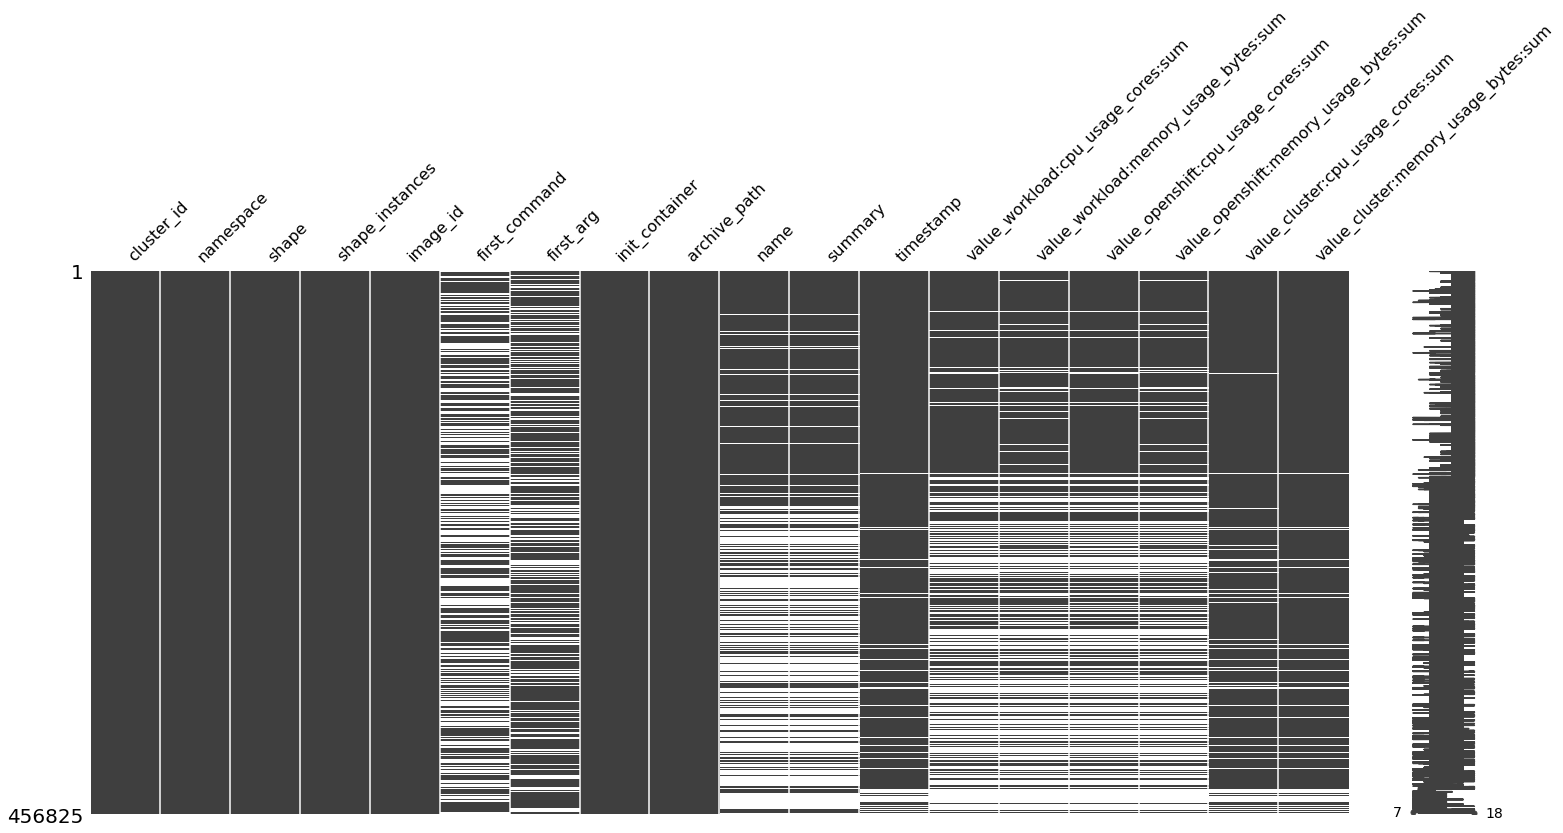

In [18]:
msno.matrix(df_cont)

Creating a report using the dataprep package and saving it as a html file.

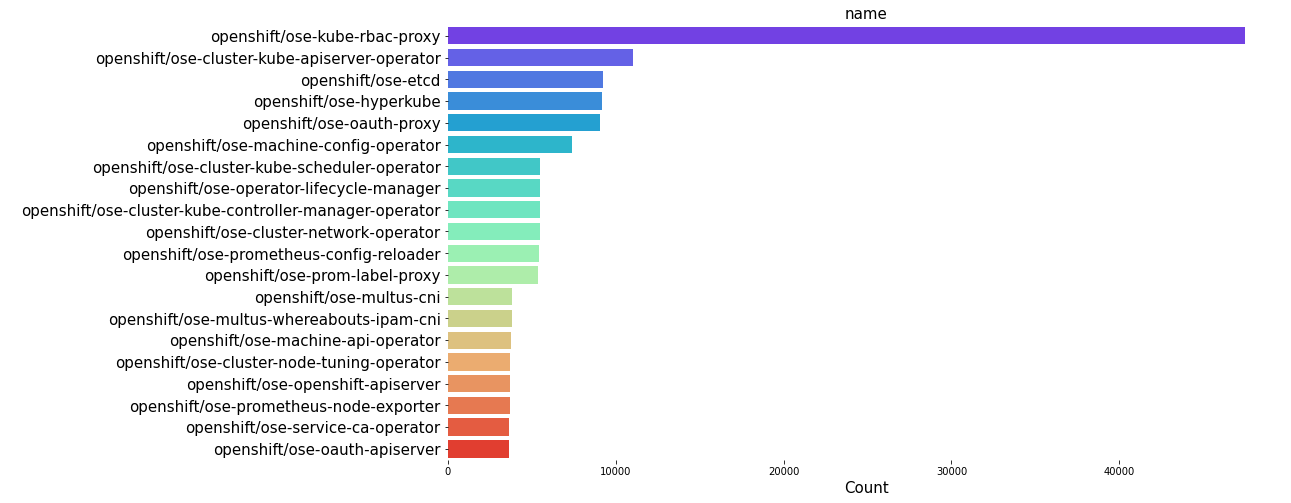

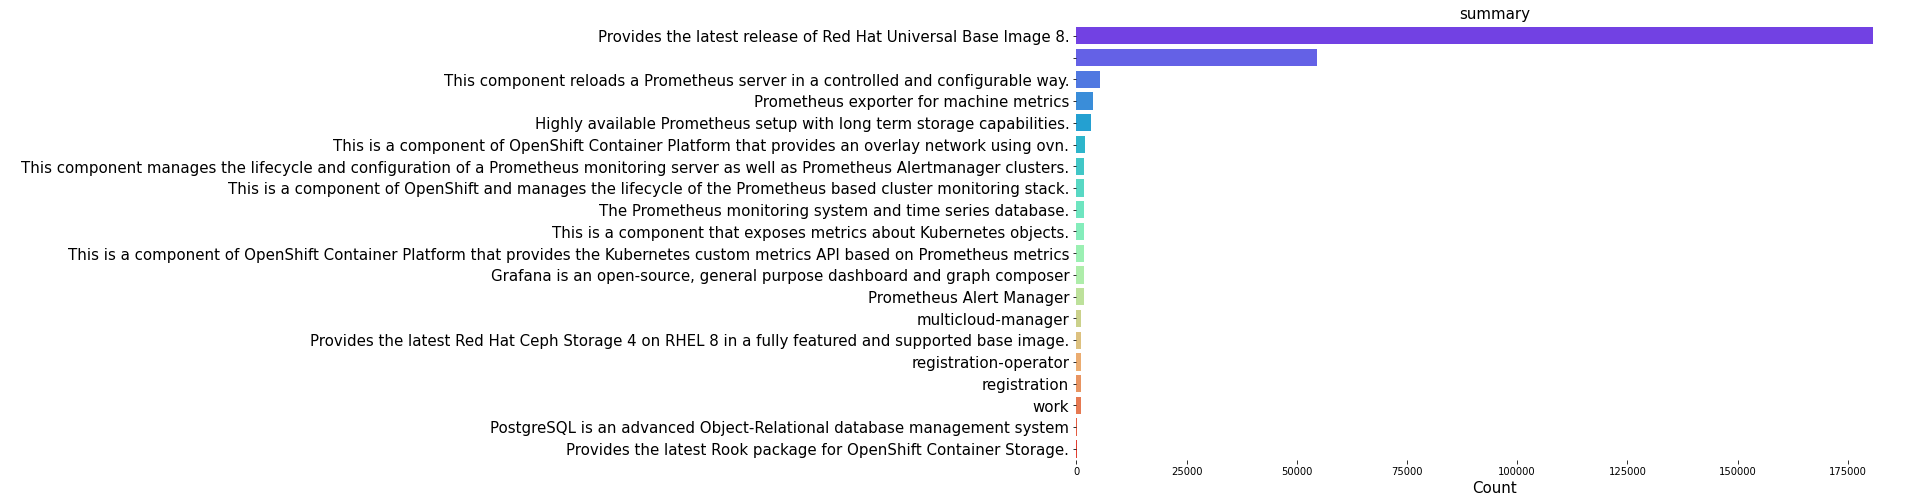

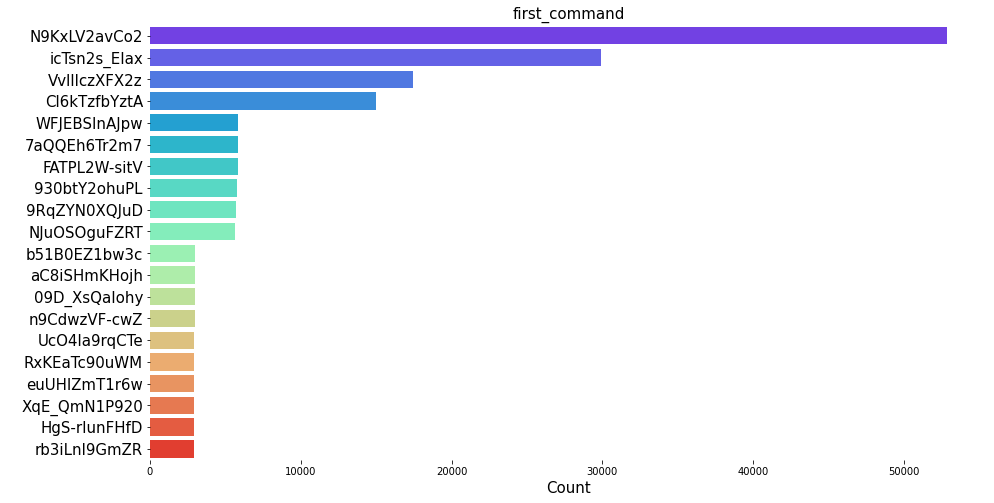

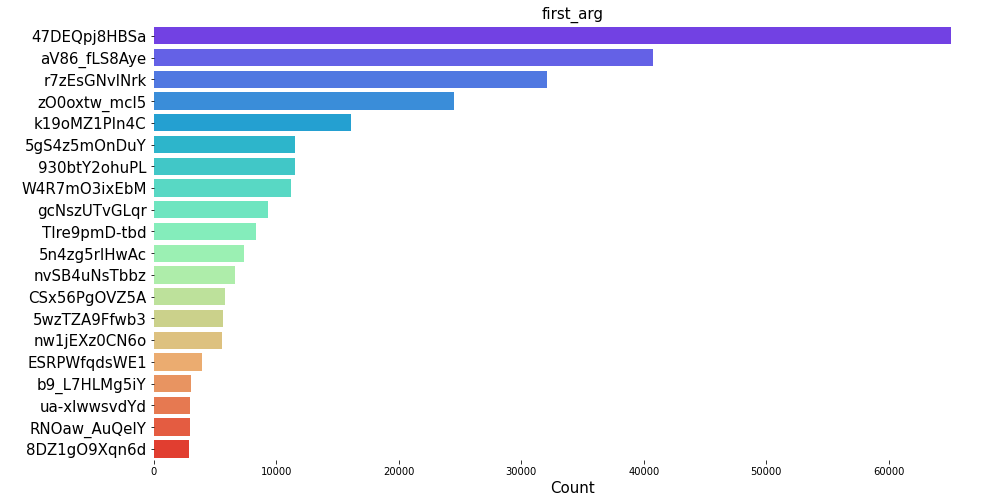

In [19]:
cont_columns = ["name", "summary", "first_command", "first_arg"]

for col in cont_columns:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    sns.countplot(
        y=df_cont[col][1:],
        data=df_cont.iloc[1:],
        order=df_cont[col][1:].value_counts().iloc[:20].index,
        palette="rainbow",
    )
    plt.title(col, fontsize=15)
    plt.xlabel("Count", fontsize=15)
    plt.ylabel(" ")
    plt.yticks(fontsize=15)
    plt.box(False)

The distribution plots for top 20 `name`, `summary`, `first_command` and `first_arg` shows that the product `openshift/ose-kube-rbac-proxy` has the highest count of all. SImilarly, from the summary, we can see that Red Hat UBI image has the maximum count. Furthermore, we can also see that certain commands and arguments are present in high amount in the container dataset.

---

## Some FAQs

### How many unique image name are there in image layer dataset and container dataset?

For the image layer dataset, the list of unique product name are listed below.

In [20]:
print(df_image.name.unique())

['openshift/ose-cli-artifacts' 'openshift/ose-cli'
 'openshift/ose-oauth-proxy' nan 'rhel8/postgresql-12'
 'rhscl/postgresql-10-rhel7' 'rhel8/redis-5' 'rhel8/postgresql-10'
 'rhscl/mongodb-36-rhel7' 'openshift/ose-tests'
 'openshift/ose-must-gather' 'jboss-amq-6/amq63-openshift'
 '3scale-amp2/system-rhel7' '3scale-amp2/apicast-gateway-rhel8'
 'rhscl/mysql-57-rhel7' 'rhscl/redis-32-rhel7' '3scale-amp2/backend-rhel7'
 '3scale-amp2/memcached-rhel7' '3scale-amp2/zync-rhel7' 'rhel8/mysql-80'
 'openshift/ose-jenkins' 'ubi8/ruby-27' 'openshift/ose-tools'
 'ubi8/dotnet-50' 'openshift/ose-grafana' 'rhel8/httpd-24']


In [21]:
print(
    "The number of unique image name extracted for image layer dataset is :",
    df_image.name.nunique(),
)

The number of unique image name extracted for image layer dataset is : 25


For the container dataset, the list of unique product names are list below:

In [22]:
print(df_cont.name.unique())

['openshift/ose-kube-rbac-proxy'
 'openshift/ose-multus-admission-controller' 'openshift/ose-multus-cni'
 'openshift/ose-egress-router-cni'
 'openshift/ose-container-networking-plugins'
 'openshift/ose-multus-route-override-cni'
 'openshift/ose-multus-whereabouts-ipam-cni'
 'openshift/ose-network-metrics-daemon'
 'openshift/ose-cluster-config-operator' nan
 'openshift/ose-operator-marketplace' 'openshift/ose-etcd'
 'openshift/ose-hyperkube' 'openshift/ose-cluster-kube-scheduler-operator'
 'openshift/ose-cluster-storage-operator'
 'openshift/ose-csi-snapshot-controller'
 'openshift/ose-cluster-csi-snapshot-controller-operator'
 'openshift/ose-csi-snapshot-validation-webhook'
 'openshift/ose-oauth-server'
 'openshift/ose-kube-storage-version-migrator'
 'openshift/ose-cluster-policy-controller'
 'openshift/ose-cluster-kube-controller-manager-operator'
 'openshift/ose-service-ca-operator'
 'openshift/ose-operator-lifecycle-manager'
 'openshift/ose-cloud-credential-operator'
 'openshift/ose

In [23]:
print(
    "The number of unique image name extracted for image layer dataset is :",
    df_cont.name.nunique(),
)

The number of unique image name extracted for image layer dataset is : 353


---

### Popular images and groups of images occuring in a cluster

To address this question, we try to find the correlation between different image sha's and the cluster_id's see if there are any images that occur together. We make use of the crosstab function, which builds a cross tabulation table that can show the frequency with which certain groups of data appears.

#### Image Layers dataset

Lets apply cross tabulation for the SHA's in image_id with different cluster_id's, for image layers

From the above heat map, we can qualitatively see that, there are some group of image_names occuring together in a clusters.

<AxesSubplot:xlabel='cluster_id', ylabel='name'>

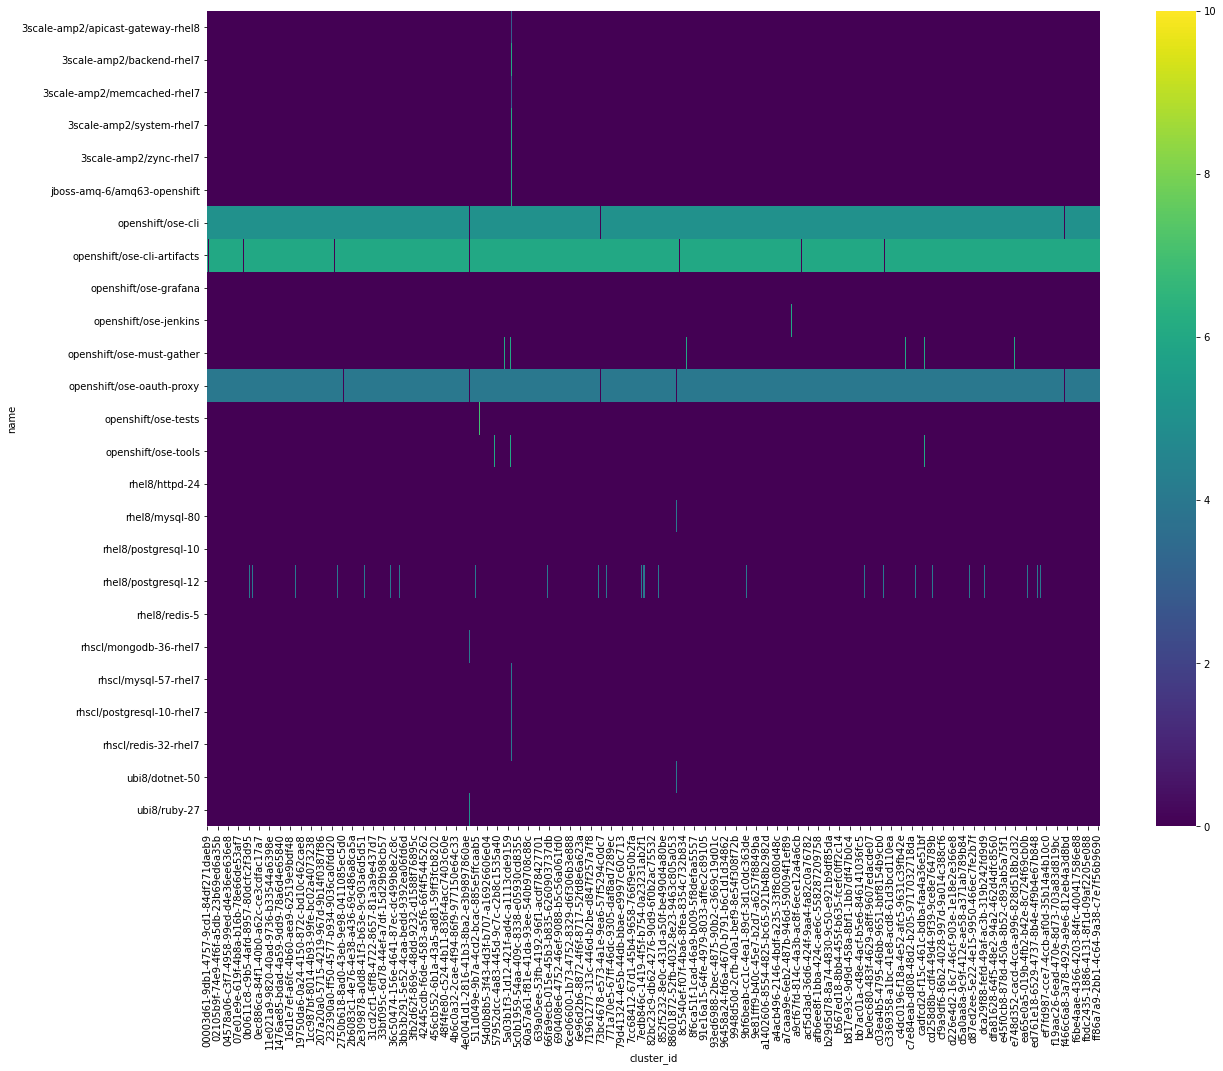

In [24]:
d3 = df_image["name"]
d4 = df_image["cluster_id"]

crosstab = pd.crosstab(d3, d4)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstab, cmap="viridis", annot=False)

The heat map shows more clearer view of the distribution of products across different clusters. We observe that image name such as, _**openshift/ose-cli-artifacts**_, _**openshift/ose-cli**_, _**openshift/ose-oauth-proxy**_ are present in alomost all clusters. The lighter patches shows us the image name present in cluster_ids. For example, for the image name, `rhscl/mysql-57-rhel7`, `rhscl/postgresql-10-rhel7`, and `rhscl/redis-32-rhel7` are found to occur together.

In [25]:
s0 = df_image.groupby("name")["cluster_id"].nunique()
s0 = s0.reset_index().sort_values(by="cluster_id", ascending=False)
s0.head(20)

,name,cluster_id
6,openshift/ose-cli,1805
11,openshift/ose-oauth-proxy,1801
7,openshift/ose-cli-artifacts,1799
17,rhel8/postgresql-12,50
10,openshift/ose-must-gather,13
13,openshift/ose-tools,13
19,rhscl/mongodb-36-rhel7,3
15,rhel8/mysql-80,3
24,ubi8/ruby-27,2
21,rhscl/postgresql-10-rhel7,2


If we plot the image name with corresponding number of cluster_id it is present in. We have,

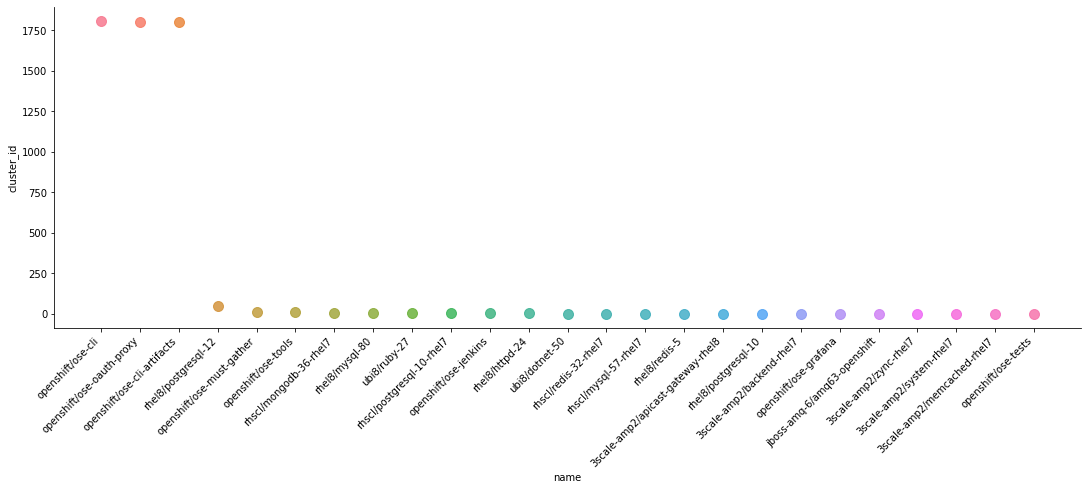

In [26]:
g = sns.lmplot(
    x="name",
    y="cluster_id",
    data=s0,
    fit_reg=False,
    hue="name",
    legend_out=True,
    aspect=10 / 3.3,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Image Name")
g._legend.remove()
plt.xticks(s0.name, rotation=45, horizontalalignment="right")
plt.show()

---

#### Containers dataset

Performing the similar actions for container dataset image id.

Checking the distribution of image repos for different cluster id.

<AxesSubplot:xlabel='cluster_id', ylabel='name'>

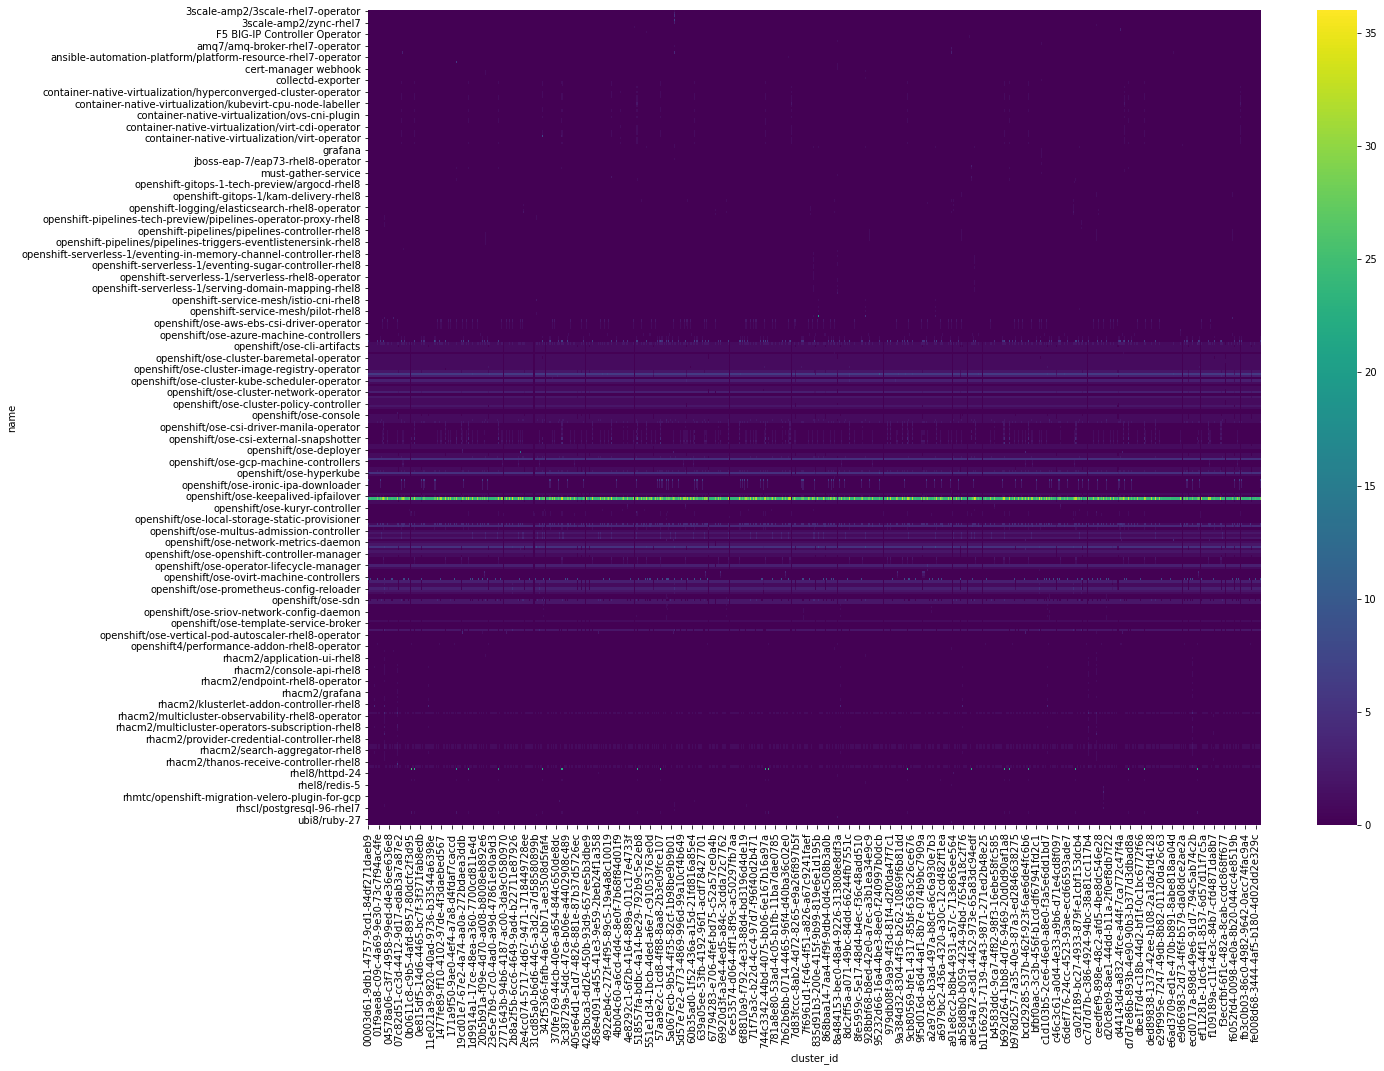

In [27]:
d7 = df_cont["name"]
d8 = df_cont["cluster_id"]

crosstab1 = pd.crosstab(d7, d8)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstab1, cmap="viridis", annot=False)

Here, we do see a dominant product present in the heat map. Now, listing out the most common products name,

In [28]:
s1 = df_cont.groupby("name")["cluster_id"].nunique()
s1 = s1.reset_index().sort_values(by="cluster_id", ascending=False)
s1.head(10)

,name,cluster_id
167,openshift/ose-cluster-node-tuning-operator,1848
168,openshift/ose-cluster-openshift-apiserver-oper...,1848
157,openshift/ose-cluster-kube-apiserver-operator,1848
146,openshift/ose-cloud-credential-operator,1848
151,openshift/ose-cluster-config-operator,1848
211,openshift/ose-kube-rbac-proxy,1848
163,openshift/ose-cluster-machine-approver,1848
147,openshift/ose-cluster-authentication-operator,1847
172,openshift/ose-cluster-storage-operator,1847
152,openshift/ose-cluster-csi-snapshot-controller-...,1847


There are total of 353 image names linked to the container dataset. Hence, we divide the  image name list into two parts. One related to `openshift` and other not related to `openshift`.

### Extracting list from a Job Run Output

   As per the suggestions from the ccx team, there are list of OpenShift repos which does not contain the word OpenShift in it. For example, `aws-ebs-csi-driver` is an OpenShift repo. Hence, if we filter out the list of repos based on word `OpenShift`, we may exclude those OpenShift repos which does not have the word `OpenShift` in them. Ivans Necas, from CCX team provided us with the list of [OpenShift repos](https://openshift-release.apps.ci.l2s4.p1.openshiftapps.com/releasetag/4.8.1?from=4.8.0-rc.1). In this section we extract the list of OpenShift repos from the link provided.

In [29]:
IFrame(
    "https://openshift-release.apps.ci.l2s4.p1.openshiftapps.com/releasetag/4.8.1?from=4.8.0-rc.1",
    width=800,
    height=450,
)

In [30]:
r = requests.get(
    "https://openshift-release.apps.ci.l2s4.p1.openshiftapps.com/releasetag/4.8.1?from=4.8.0-rc.1"
)
docs = BeautifulSoup(r.content, "lxml")
body = docs.body

In [31]:
word_list1 = []
for i in range(23, 141):
    txt = body.find("div", {"class": "container"}).find_all("li")[i].text
    word = txt.split()[0]
    word_list1.append(word)

In [32]:
word_list2 = []
for i in range(2, 8):
    txt = body.find("div", {"class": "container"}).find_all("h3")[i].text
    word = txt.split()[0]
    word_list2.append(word)

In [33]:
openshift_list = word_list1 + word_list2

In [34]:
openshift_list

['Kubernetes',
 'Red',
 'aws-ebs-csi-driver',
 'aws-ebs-csi-driver-operator',
 'aws-machine-controllers',
 'azure-disk-csi-driver',
 'azure-disk-csi-driver-operator',
 'azure-machine-controllers',
 'baremetal-installer',
 'baremetal-machine-controllers',
 'baremetal-operator',
 'baremetal-runtimecfg',
 'cli',
 'cli-artifacts',
 'cloud-credential-operator',
 'cluster-autoscaler',
 'cluster-autoscaler-operator',
 'cluster-baremetal-operator',
 'cluster-bootstrap',
 'cluster-config-operator',
 'cluster-csi-snapshot-controller-operator',
 'cluster-etcd-operator',
 'cluster-image-registry-operator',
 'cluster-ingress-operator',
 'cluster-kube-apiserver-operator',
 'cluster-kube-scheduler-operator',
 'cluster-kube-storage-version-migrator-operator',
 'cluster-machine-approver',
 'cluster-network-operator',
 'cluster-openshift-apiserver-operator',
 'cluster-openshift-controller-manager-operator',
 'cluster-policy-controller',
 'cluster-samples-operator',
 'cluster-storage-operator',
 'cluster

In [35]:
len(openshift_list)

124

We have extracted list of OpenShift repos as mentioned in this [link](https://openshift-release.apps.ci.l2s4.p1.openshiftapps.com/releasetag/4.8.1?from=4.8.0-rc.1). Now, in the next section, we use the extracted list to filter out the OpenShift related and NOT related repos.  

#### Top 50 Image Repos

**Filtering out the opensift related repos**

In [36]:
openshift_list.append("openshift")
rstr = "|".join(openshift_list)
new_s1_os = s1[s1["name"].str.contains(rstr)]
new_s1_os.head(50)

,name,cluster_id
167,openshift/ose-cluster-node-tuning-operator,1848
168,openshift/ose-cluster-openshift-apiserver-oper...,1848
157,openshift/ose-cluster-kube-apiserver-operator,1848
146,openshift/ose-cloud-credential-operator,1848
151,openshift/ose-cluster-config-operator,1848
211,openshift/ose-kube-rbac-proxy,1848
163,openshift/ose-cluster-machine-approver,1848
147,openshift/ose-cluster-authentication-operator,1847
172,openshift/ose-cluster-storage-operator,1847
152,openshift/ose-cluster-csi-snapshot-controller-...,1847


**Plotting them with respect to cluster_id**

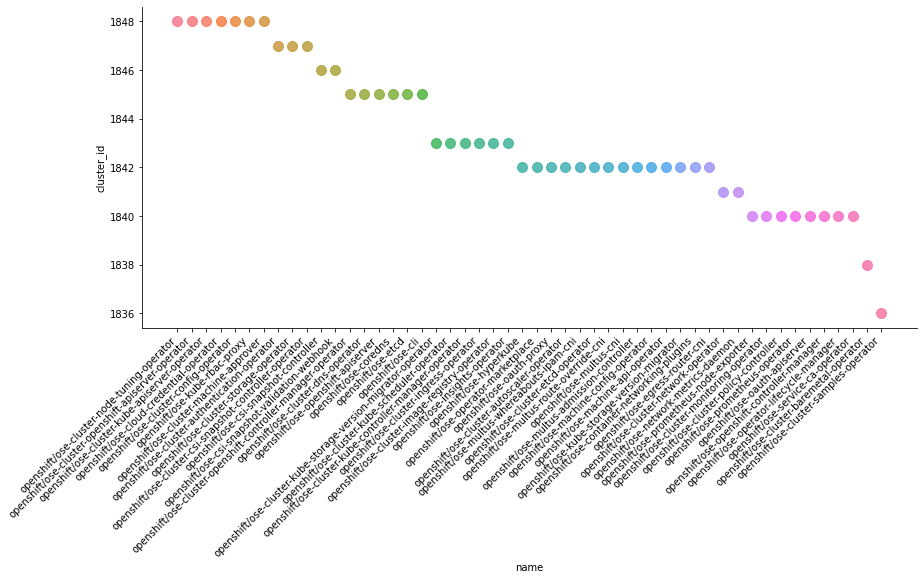

In [37]:
new_s1_os50 = new_s1_os.head(50)
g = sns.lmplot(
    x="name",
    y="cluster_id",
    data=new_s1_os50,
    fit_reg=False,
    hue="name",
    legend_out=True,
    aspect=10 / 4,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Image Name")
g.legend.remove()
plt.xticks(new_s1_os50.name, rotation=45, horizontalalignment="right")
plt.show()

#### Least 50 Image Repos

Now listing the least 50 image name related to openshift.

In [38]:
new_s1_osl50 = new_s1_os.tail(50)
new_s1_osl50

,name,cluster_id
90,openshift-pipelines-tech-preview/pipelines-ope...,2
107,openshift-serverless-1/eventing-mtbroker-ingre...,2
89,openshift-pipelines-tech-preview/pipelines-con...,2
109,openshift-serverless-1/eventing-mtping-rhel8,2
111,openshift-serverless-1/eventing-webhook-rhel8,2
83,openshift-logging/elasticsearch-operator-bundle,2
120,openshift-serverless-1/serving-domain-mapping-...,2
74,openshift-compliance-content,2
166,openshift/ose-cluster-nfd-operator,2
208,openshift/ose-jenkins,2


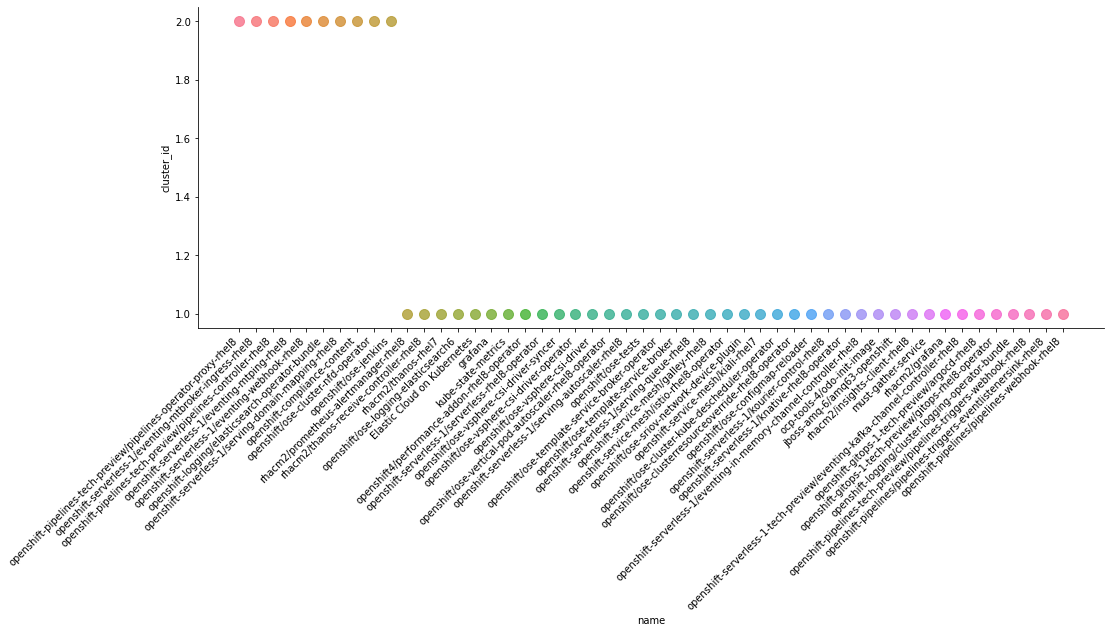

In [39]:
g = sns.lmplot(
    x="name",
    y="cluster_id",
    data=new_s1_osl50,
    fit_reg=False,
    hue="name",
    legend_out=True,
    aspect=10 / 3.3,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Image Name")
g.legend.remove()
plt.xticks(new_s1_osl50.name, rotation=45, horizontalalignment="right")
plt.show()

---

In the next section, we plot top 50 image name not related to `openshift`.

#### Top 50 Image Repos

In [40]:
new_s1_nos = s1[~s1["name"].str.contains(rstr)]
new_s1_nos.head(50)

,name,cluster_id
319,rhacm2/registration-rhel8-operator,1065
304,rhacm2/multicloud-manager-rhel8,1063
318,rhacm2/registration-rhel8,1062
327,rhacm2/work-rhel8,1048
333,rhel8/postgresql-12,51
43,container-native-virtualization/node-maintenan...,51
328,rhceph,49
347,rook-ceph,49
37,container-native-virtualization/kubemacpool,46
38,container-native-virtualization/kubernetes-nms...,45


Now, plotting the top image name with respect to the number of cluster_id it is present in.

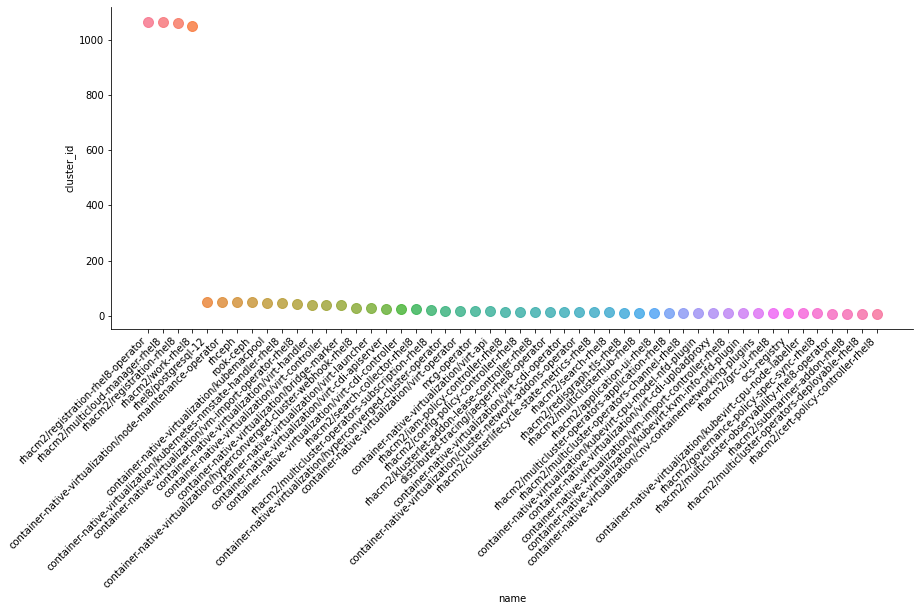

In [41]:
new_s1_nos50 = new_s1_nos.head(50)
g = sns.lmplot(
    x="name",
    y="cluster_id",
    data=new_s1_nos50,
    fit_reg=False,
    hue="name",
    legend_out=True,
    aspect=10 / 4,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Image Name")
g.legend.remove()
plt.xticks(new_s1_nos50.name, rotation=45, horizontalalignment="right")
plt.show()

#### Least 50 Image repos

In [42]:
new_s1_nos.tail(50)

,name,cluster_id
352,volume-replication-operator,2
7,Cilium,2
17,amq7/amq-streams-kafka-26-rhel7,2
16,amq7/amq-streams-kafka-25-rhel7,2
13,Seldon Operator,2
26,codeready-workspaces/devfileregistry-rhel8,2
28,codeready-workspaces/pluginregistry-rhel8,2
58,costmanagement-metrics-operator,2
44,container-native-virtualization/ovs-cni-marker,2
29,codeready-workspaces/server-rhel8,1


Now, plotting the least 50 image name with respect to the number of cluster_id it is present in.

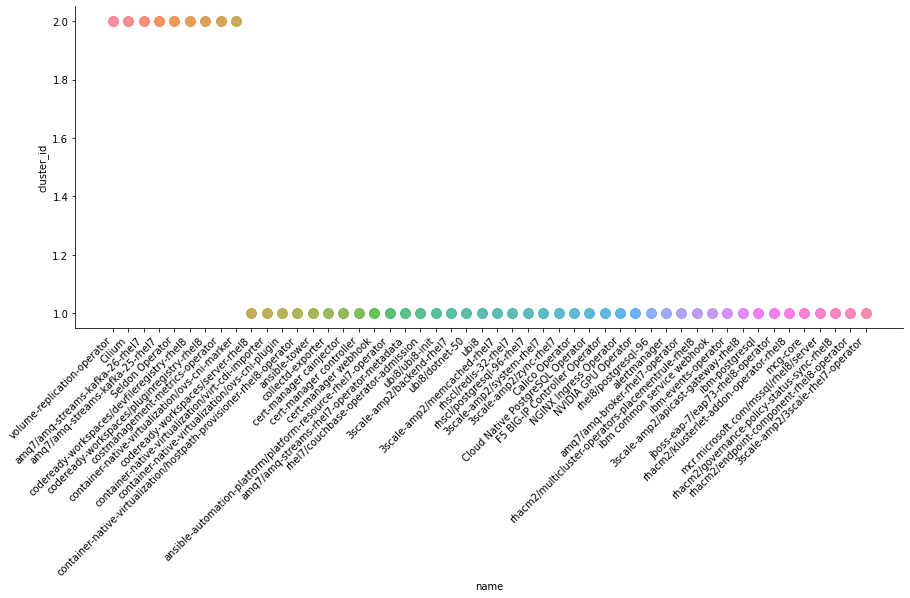

In [43]:
new_s1_nos50 = new_s1_nos.tail(50)
g = sns.lmplot(
    x="name",
    y="cluster_id",
    data=new_s1_nos50,
    fit_reg=False,
    hue="name",
    legend_out=True,
    aspect=10 / 4,
    scatter_kws={"s": 100},
)
# plt.figsize(16,10)
g._legend.set_title("Image Name")
g.legend.remove()
plt.xticks(new_s1_nos50.name, rotation=45, horizontalalignment="right")
plt.show()

---

### What are the most popular commands and what args are they called with?

To address this query, we used the groupby method to form a dataframe which would give us the list of commands and the corresponding argument that corresponds to the particular command in the dataset. 

In [44]:
# For the image_layer dataset : df_image
df3 = df_image[["first_command", "first_arg"]]
df3 = df3.groupby(["first_command", "first_arg"]).size()
df3 = df3.to_frame()
df3.rename(columns={0: "frequency"}, inplace=True)
df3 = df3.sort_values(by=["frequency"], ascending=False)
df3.head(50)

frequency
first_command first_arg              
icTsn2s_EIax  2v1NneeWoS_9      27234
lwp1IAZLTWcp  icTsn2s_EIax        649
icTsn2s_EIax  icTsn2s_EIax         26
eXOGhaZW_msl  icTsn2s_EIax         25
              15Z3GIaH57Mr         18
              KVNJDjO6_knB         13
b51B0EZ1bw3c  icTsn2s_EIax         12
lwp1IAZLTWcp  h45OnGCW1OSR         11
Poq-znsLooiE  47DEQpj8HBSa         10
b51B0EZ1bw3c  zO0oxtw_mcI5          9
N9KxLV2avCo2  icTsn2s_EIax          6
R2zXWhUnSgIM  icTsn2s_EIax          6
c8xKHtkOWaJH  icTsn2s_EIax          5
Ad4Rg1Av8Y0X  icTsn2s_EIax          4
3C4BfYP4q5EN  icTsn2s_EIax          4
nxKqHhNS6WsO  icTsn2s_EIax          3
buSkac1OkQU4  icTsn2s_EIax          3
2B5peo-_Thrw  icTsn2s_EIax          2

Lets try to visualize it with the help of cross tabulation table. 

<AxesSubplot:xlabel='first_arg', ylabel='first_command'>

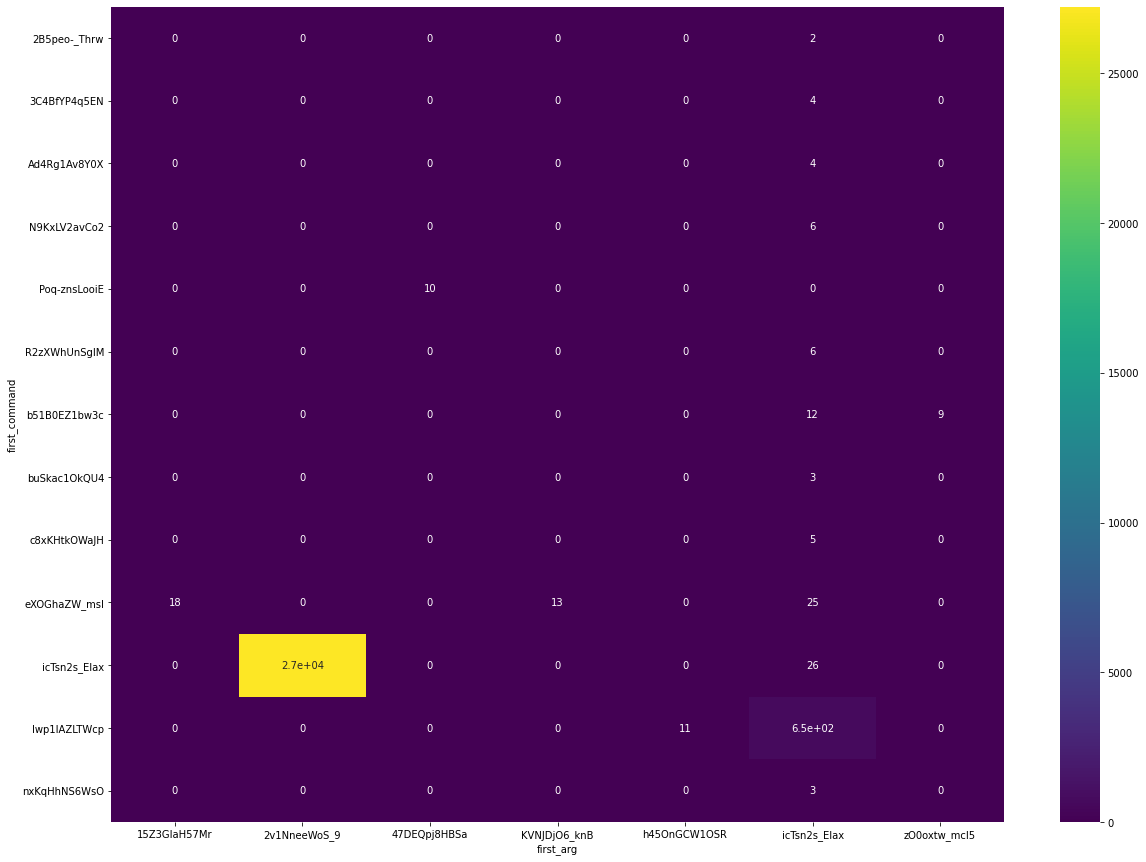

In [45]:
c1 = df_image["first_command"]
c2 = df_image["first_arg"]

crosstabc = pd.crosstab(c1, c2)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstabc, cmap="viridis", annot=True)

The dataframe above represents the list of first commands and their corresponding arguments and their frequency (number of times they appeared in the dataset). Most of the _first commands_ have a corresponding single _first_arg_. But there are some _first_commands_ in the dataset which corresponds to multiple _first_arg_. E.g. for first command, **eXOGhaZW_msl**, we have **icTsn2s_EIax**, **15Z3GIaH57Mr**, and **KVNJDjO6_knB** as corresponding first arguments. The frequencies of each are shown on the column next to it. The annotation in the cross tabulation table gives a better pictorial view about the distribution of different commands and argument.

We also explored the same query in the container dataset: _df_cont_

In [46]:
# For the containers dataset : df_cont
df4 = df_cont[["first_command", "first_arg"]]
df4 = df4.groupby(["first_command", "first_arg"]).size()
df4 = df4.to_frame()
df4.rename(columns={0: "frequency"}, inplace=True)
df4 = df4.sort_values(by=["frequency"], ascending=False)
df4.head(10)

frequency
first_command first_arg              
N9KxLV2avCo2  k19oMZ1PIn4C      16108
              930btY2ohuPL      11509
VvlllczXFX2z  47DEQpj8HBSa       5779
930btY2ohuPL  CSx56PgOVZ5A       5764
VvlllczXFX2z  5gS4z5mOnDuY       5730
NJuOSOguFZRT  nw1jEXz0CN6o       5610
b51B0EZ1bw3c  ua-xlwwsvdYd       2995
n9CdwzVF-cwZ  RNOaw_AuQeIY       2939
RxKEaTc90uWM  r7zEsGNvlNrk       2925
XqE_QmN1P920  r7zEsGNvlNrk       2924

<AxesSubplot:xlabel='first_arg', ylabel='first_command'>

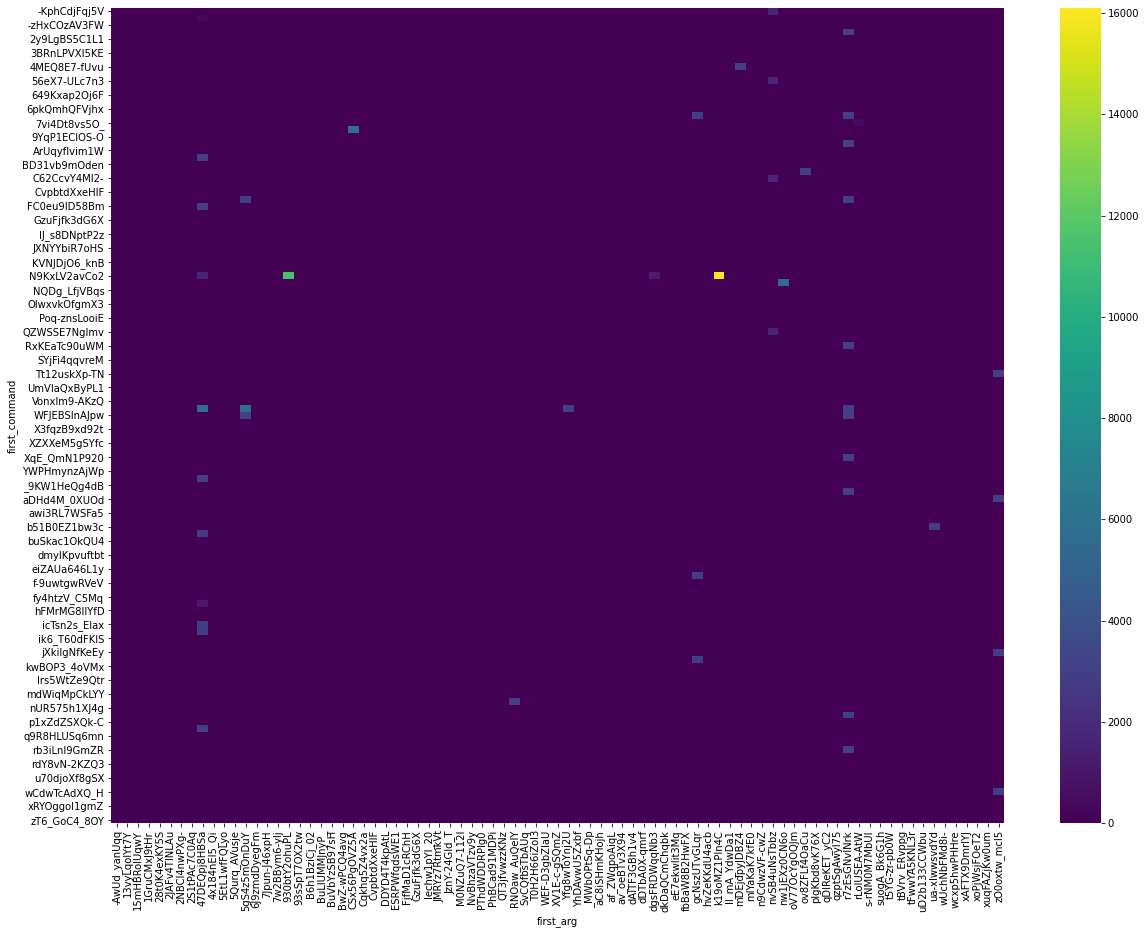

In [47]:
c3 = df_cont["first_command"]
c4 = df_cont["first_arg"]

crosstabc1 = pd.crosstab(c3, c4)
plt.figure(figsize=(20, 15))
sns.heatmap(crosstabc1, cmap="viridis", annot=False)

The _first command_ and _first argument_ information are unclear in the dataset we are working on. From the dataset, we can only have an information about the proportion of different commands and arguments in the dataset involved. The cross tabulation does highlight some highly correlated first_command and argument.

---

### Is customer cluster is empty, testing or full? 

In [48]:
cont_image4 = (
    df_cont.groupby(["cluster_id"])
    .agg({"shape_instances": pd.Series.nunique})
    .reset_index()
    .sort_values(by=["shape_instances"], ascending=True)
)
cont_image4.head(10)

,cluster_id,shape_instances
2456,d46df89c-cb5c-467c-bde6-109d2d440031,1
2216,c04ca332-ac85-4fd6-837c-c24f6c09f1b4,1
1102,618a5444-bb49-45eb-ac27-1949e175c4a1,1
2548,dcb7efad-feb6-45be-9a7d-ea608f26278f,1
0,00003d61-9db1-4757-9cd1-84df271daeb9,2
1793,9c8535e9-a21c-4585-8102-07e5f33c8c92,2
1796,9cb80569-bfe1-4317-85bf-6363c26ce676,2
1797,9ceb42ff-772d-4cdf-b9eb-c6b3b0a1e628,2
792,474f7a6a-cfbe-4ac2-9644-7c4013c34367,2
1798,9d3bfcd9-4914-409c-8ec5-13ba43c4a7e9,2


To address this query, we try to look for those cluster_id/image_id and the minimum number of shape_instances, which defines the number of POD of certain shape. We observe that no cluster is empty. Each cluster is running atleast one POD, defined by the shape instances.

---

### How many users are deploying HA configurations?

HA (High availability) configurations are the POD with 3 or more replicas. The query refers to finding the cluster_id with 3 or more shape instances. Shape instances is defined as the number of PODs of particular shape. Hence, if we generate a dataframe which list out the cluster_id and corresponding shape instances. We will have the information about the number of users deploying HA configurations. 

In [49]:
cont_image5 = df_cont[["cluster_id", "shape_instances"]]

Cluster_id containing 3 or more shape instances:

In [50]:
cont_image5 = cont_image5[(cont_image5["shape_instances"] >= 3)]
cont_image5 = cont_image5.sort_values(by="shape_instances", ascending=False)
cont_image5.head(10)

,cluster_id,shape_instances
260457,8505f31a-ba37-4e67-9441-0863b38b23c1,1500
183507,70795f27-2ccc-4719-ae89-2ad33f2bce93,683
197315,ebf54a64-9c86-4281-850d-f8764aece456,500
245889,645eecc4-917b-43e1-a2d0-eba9781d406c,500
245890,645eecc4-917b-43e1-a2d0-eba9781d406c,500
245891,645eecc4-917b-43e1-a2d0-eba9781d406c,500
197313,ebf54a64-9c86-4281-850d-f8764aece456,500
188662,9894d014-e1cd-4e39-b114-15490988b9f0,500
197316,ebf54a64-9c86-4281-850d-f8764aece456,500
245892,645eecc4-917b-43e1-a2d0-eba9781d406c,500


Hence, the number of cluster_id deploying HA configurations are,

In [51]:
cont_image5.cluster_id.nunique()

1767

Total number of unique cluster_id: 

In [52]:
df_cont.cluster_id.nunique()

2927

**Hence, out of 2927 cluster_id, 1767, i.e, ~60% of the total cluster id have HA configuration.**

---

### What are the most common base images?

To answer this question, we will look at the pyxis metadata for the image SHA's in the layer_image_id column.

**Out of total 752 image_layer_ids, we could only map 143 sha's.**

In [53]:
image_layer_idmap[["layer_image_id", "name"]].head()
df_image1 = df_image[["layer_image_id", "layer_image_level"]]
image_layer_idmap = image_layer_idmap[["layer_image_id", "name"]]

df_layer = pd.merge(df_image1, image_layer_idmap, on="layer_image_id", how="inner")
df_layer.groupby("layer_image_level").name.value_counts().to_frame()

name
layer_image_level name                                            
0                 Watson Assistant CLU Sire GRPC Server          2
                  hdm/common-zookeeper                           1
                  redislabs/k8s-controller                       1
1                 ubi8                                        2406
                  ubi7                                          21
                  rhel7                                         10
                  ubi8-minimal                                   4
2                 ubi8/s2i-core                                 94
                  rhscl/s2i-core-rhel7                          27
                  dotnet/dotnet-31-runtime-rhel7                 5
                  ubi8/dotnet-50-runtime                         3
                  openjdk/openjdk-11-rhel7                       2
                  3scale-amp2/apicast-gateway-rhel8              1
                  3scale-amp2/memcached-rhel7                    1
                  dotnet/dotnet-30-runtime-rhel7                 1
                  jboss-eap-7/eap73-openjdk8-openshift-rhel7     1
                  redhat-openjdk-18/openjdk18-openshift          1
                  rhel8/buildah                                  1
                  ubi8/dotnet-31-runtime                         1
3                 rhel8/postgresql-12                           50
                  ubi8/s2i-base                                 27
                  rhscl/s2i-base-rhel7                          13
                  ubi8/nodejs-14                                 7
                  dotnet/dotnet-31-rhel7                         5
                  rhel8/httpd-24                                 4
                  rhscl/nodejs-14-rhel7                          4
                  rhel8/mysql-80                                 3
                  rhscl/mongodb-36-rhel7                         3
                  ubi8/dotnet-50                                 3
                  openshift/ose-oauth-proxy                      2
                  rhscl/nginx-118-rhel7                          2
                  rhscl/postgresql-10-rhel7                      2
                  dotnet/dotnet-30-rhel7                         1
                  fuse7/fuse-karaf-openshift                     1
                  rhel8/postgresql-10                            1
                  rhel8/redis-5                                  1
                  rhscl/httpd-24-rhel7                           1
                  rhscl/mysql-57-rhel7                           1
                  rhscl/redis-32-rhel7                           1
                  ubi8/dotnet-31                                 1
                  ubi8/nginx-118                                 1
4                 ubi8/nodejs-12                                10
                  ubi8/php-73                                    6
                  rhscl/python-36-rhel7                          4
                  rhscl/ruby-25-rhel7                            3
                  ubi8/ruby-26                                   3
                  rhscl/perl-530-rhel7                           2
                  rhscl/ruby-27-rhel7                            2
                  ubi8/php-74                                    2
                  ubi8/ruby-27                                   2
                  openshift/ose-grafana                          1
                  rhel8/go-toolset                               1
                  rhscl/php-72-rhel7                             1
                  rhscl/python-38-rhel7                          1
                  ubi8/perl-526                                  1
                  ubi8/perl-530                                  1
                  ubi8/python-38                                 1
5                 3scale-amp2/backend-rhel7                      1
                  3scale-amp2/system-rhel7

---

## Plots of information extracted from the telemetry

We extracted the values for the parameters, i.e, `value_workload:cpu_usage_cores:sum`, `value_workload:memory_usage_bytes:sum` , `value_openshift:cpu_usage_cores:sum`, `value_openshift:memory_usage_bytes:sum`, `value_cluster:cpu_usage_cores:sum`, `value_cluster:memory_usage_bytes:sum`, by linking the corresponding cluster_id and timestamp given in the workload data of insight operator archive.

In this section, we plot those values with respect to the cluster_id and the corresponding product_name, for both image_layer dataset and containers dataset.

### Image_layers_dataset

Here, we plot the histograms for the values extracted from the telemetry to get an idea of how to values are distributed in the dataset.

In [54]:
# changing the dtype object to float
df_image[
    [
        "value_workload:cpu_usage_cores:sum",
        "value_workload:memory_usage_bytes:sum",
        "value_openshift:cpu_usage_cores:sum",
        "value_openshift:memory_usage_bytes:sum",
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
] = df_image[
    [
        "value_workload:cpu_usage_cores:sum",
        "value_workload:memory_usage_bytes:sum",
        "value_openshift:cpu_usage_cores:sum",
        "value_openshift:memory_usage_bytes:sum",
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
].astype(
    float
)

#### Image Repos Related to OpenShift

In [55]:
df_image1 = df_image[df_image["name"].str.contains(rstr, na=False)]

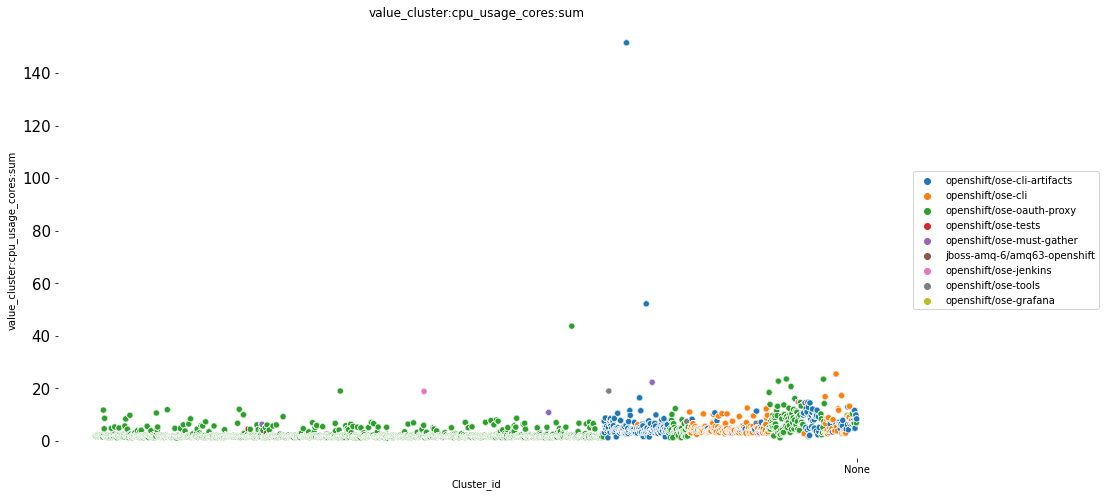

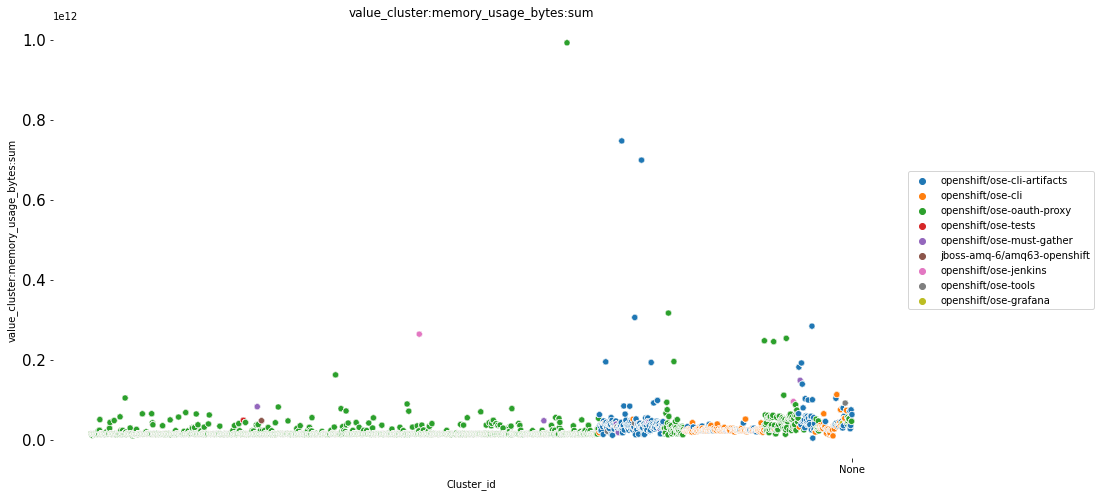

In [56]:
# Plot
image_value_columns = [
    "value_cluster:cpu_usage_cores:sum",
    "value_cluster:memory_usage_bytes:sum",
]

for col in image_value_columns:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    g = sns.scatterplot(
        x=df_image1["cluster_id"],
        y=df_image1[col],
        data=df_image1,
        hue=df_image1["name"],
        legend=True,
    )
    g.legend(loc="right", bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.title(col)
    plt.xlabel("Cluster_id")
    plt.ylabel(col)
    plt.xticks("None")
    plt.yticks(fontsize=15)
    plt.box(False)

In [57]:
d1 = (
    df_image1.groupby("name")["value_workload:cpu_usage_cores:sum"]
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)
d2 = (
    df_image1.groupby("name")["value_workload:memory_usage_bytes:sum"]
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)

dmerge = pd.merge(d1, d2, on="name", how="right")
dmerge

,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum
name,,
openshift/ose-jenkins,3.085383,8.786386e+10
jboss-amq-6/amq63-openshift,0.128574,9.641599e+09
openshift/ose-grafana,0.064348,1.348076e+09
openshift/ose-tests,0.006535,1.114124e+09
openshift/ose-tools,0.091041,9.911970e+08
openshift/ose-oauth-proxy,0.084055,8.781848e+08
openshift/ose-cli,0.082614,8.740456e+08
openshift/ose-cli-artifacts,0.082340,8.739491e+08
openshift/ose-must-gather,0.037156,4.372503e+08


The above table gives us a estimation of the cpu_usage and memory_usage values corresponding to the image_repos name from the workload image dataset.

#### Image Repos Not Related to OpenShift

In [58]:
df_image2 = df_image[~df_image["name"].str.contains(rstr, na=False)]

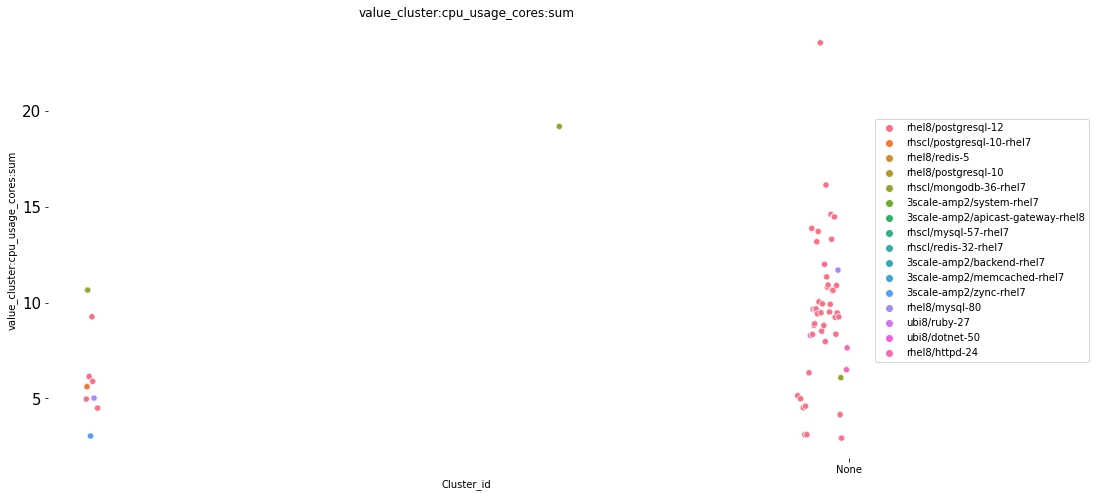

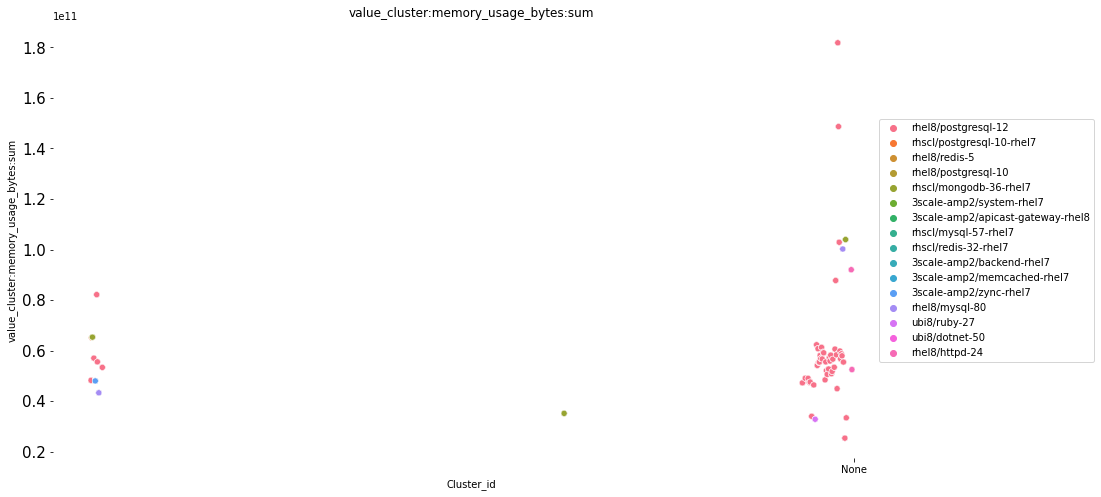

In [59]:
# Plot
image_value_columns = [
    "value_cluster:cpu_usage_cores:sum",
    "value_cluster:memory_usage_bytes:sum",
]

for col in image_value_columns:
    fig, ax = plt.subplots(1, 1, figsize=(15, 8))
    g = sns.scatterplot(
        x=df_image2["cluster_id"],
        y=df_image2[col],
        data=df_image2,
        hue=df_image2["name"],
        legend=True,
    )
    g.legend(loc="right", bbox_to_anchor=(1.25, 0.5), ncol=1)
    plt.title(col)
    plt.xlabel("Cluster_id")
    plt.ylabel(col)
    plt.xticks("None")
    plt.yticks(fontsize=15)
    plt.box(False)

In [60]:
d1 = (
    df_image2.groupby("name")["value_workload:cpu_usage_cores:sum"]
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)
d2 = (
    df_image2.groupby("name")["value_workload:memory_usage_bytes:sum"]
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)

dmerge = pd.merge(d1, d2, on="name", how="right")
dmerge

,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum
name,,
ubi8/dotnet-50,0.958828,2.842292e+10
rhscl/mongodb-36-rhel7,0.645832,2.770772e+10
rhel8/mysql-80,0.671918,1.039252e+10
3scale-amp2/apicast-gateway-rhel8,0.128574,9.641599e+09
3scale-amp2/backend-rhel7,0.128574,9.641599e+09
3scale-amp2/memcached-rhel7,0.128574,9.641599e+09
3scale-amp2/system-rhel7,0.128574,9.641599e+09
3scale-amp2/zync-rhel7,0.128574,9.641599e+09
rhscl/mysql-57-rhel7,0.128574,9.641599e+09


The above table gives us a estimation of the cpu_usage and memory_usage values corresponding to the image_repos name from the workload image dataset.

---

### Containers dataset

Here, we plot the histograms for the values extracted from the telemetry to get an idea of how to values are distributed in the dataset.

In [61]:
df_cont[
    [
        "value_workload:cpu_usage_cores:sum",
        "value_workload:memory_usage_bytes:sum",
        "value_openshift:cpu_usage_cores:sum",
        "value_openshift:memory_usage_bytes:sum",
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
] = df_cont[
    [
        "value_workload:cpu_usage_cores:sum",
        "value_workload:memory_usage_bytes:sum",
        "value_openshift:cpu_usage_cores:sum",
        "value_openshift:memory_usage_bytes:sum",
        "value_cluster:cpu_usage_cores:sum",
        "value_cluster:memory_usage_bytes:sum",
    ]
].astype(
    float
)

#### Image Repos Related to OpenShift
Since the container dataset contains huge number of products, we will show the plots for top 50 and bottom 50 products in the container dataset.

The top 20 products related to `openshift` in the containers dataset is given by,

In [62]:
os20 = new_s1_os.head(20)
os_20 = os20["name"]
os_20 = os_20.to_list()

Now, filtering the dataset with respect to the above 20 products,

In [63]:
new_cont_os_tele = df_cont[df_cont.name.isin(os_20)]

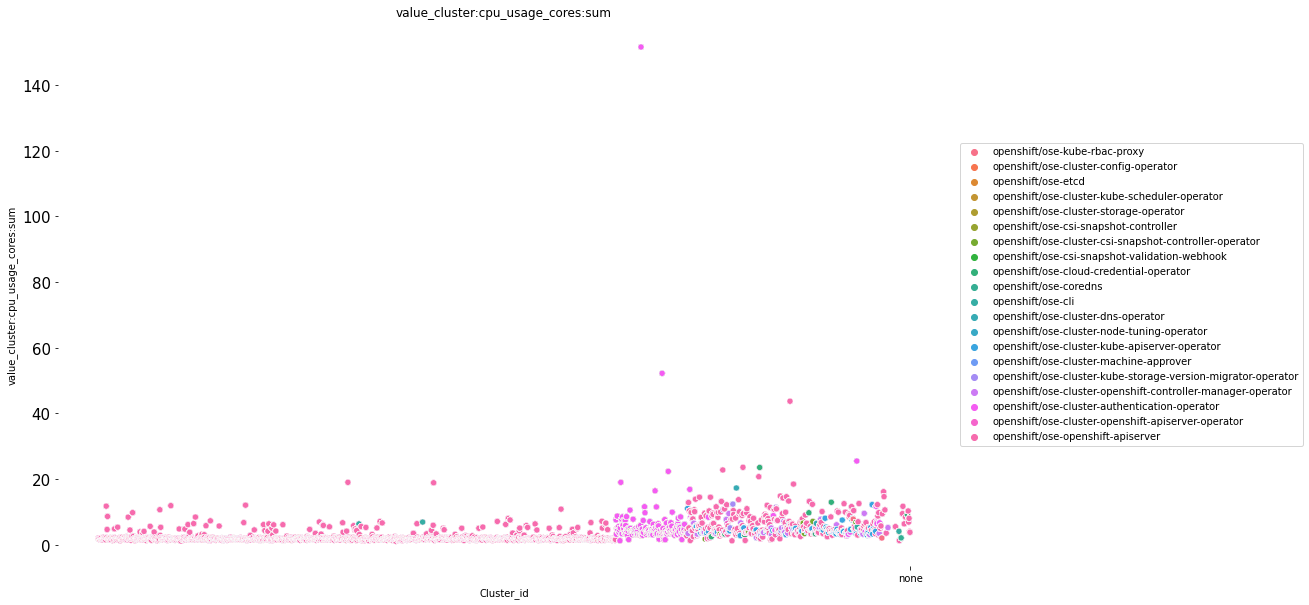

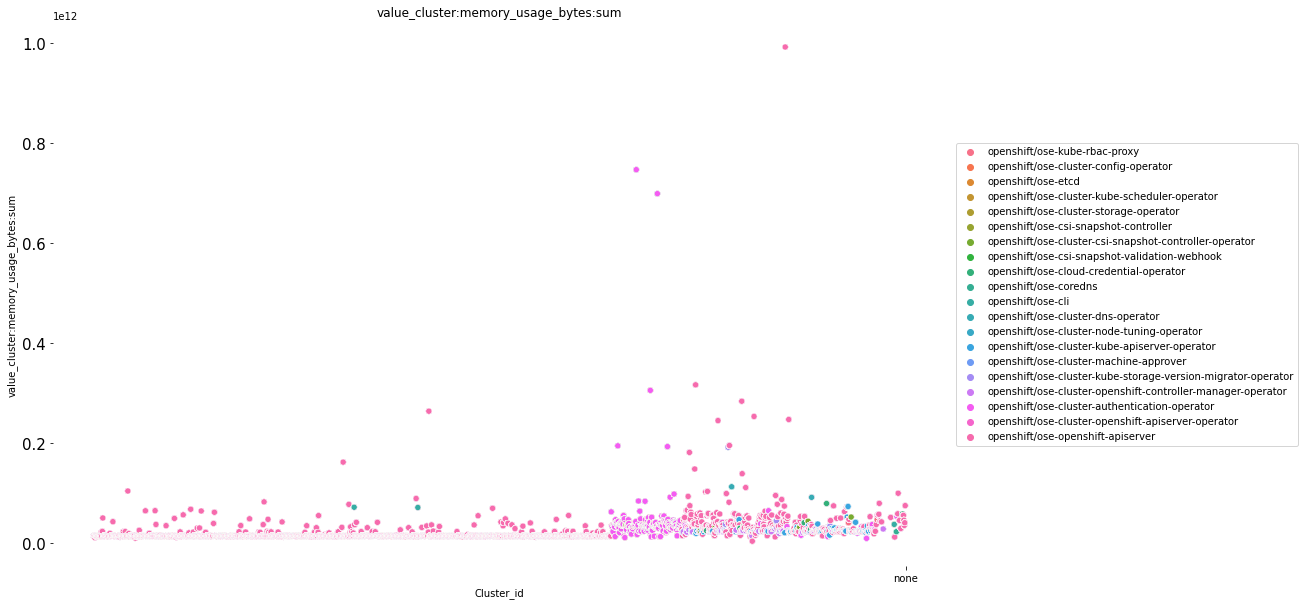

In [64]:
cont_value_columns = [
    "value_cluster:cpu_usage_cores:sum",
    "value_cluster:memory_usage_bytes:sum",
]

for col in cont_value_columns:
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    g = sns.scatterplot(
        x=new_cont_os_tele["cluster_id"],
        y=new_cont_os_tele[col],
        data=new_cont_os_tele,
        hue=new_cont_os_tele["name"],
        legend=True,
    )
    g.legend(loc="right", bbox_to_anchor=(1.40, 0.5), ncol=1)
    plt.title(col)
    plt.xlabel("Cluster_id")
    plt.ylabel(col)
    plt.xticks("none")
    plt.yticks(fontsize=15)
    plt.box(False)

In [65]:
d1 = (
    new_cont_os_tele.groupby("name")["value_workload:cpu_usage_cores:sum"]
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)
d2 = (
    new_cont_os_tele.groupby("name")["value_workload:memory_usage_bytes:sum"]
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)

dmerge = pd.merge(d1, d2, on="name", how="right")
dmerge

,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum
name,,
openshift/ose-cli,0.111619,1.179235e+09
openshift/ose-kube-rbac-proxy,0.090428,9.167763e+08
openshift/ose-coredns,0.097412,8.802308e+08
openshift/ose-cloud-credential-operator,0.082614,8.734235e+08
openshift/ose-etcd,0.082614,8.734235e+08
openshift/ose-csi-snapshot-validation-webhook,0.082614,8.734235e+08
openshift/ose-csi-snapshot-controller,0.082614,8.734235e+08
openshift/ose-cluster-openshift-controller-manager-operator,0.082614,8.734235e+08
openshift/ose-cluster-openshift-apiserver-operator,0.082614,8.734235e+08



The above table gives us a estimation of the cpu_usage and memory_usage values corresponding to the image_repos name from the workload containers dataset.

#### Image Repos Not Related to OpenShift
Next, we plot the values for top 20 products not related to `openshift`

In [66]:
nos20 = new_s1_nos.head(20)
nos_20 = nos20["name"]
nos_20 = nos_20.to_list()

In [67]:
new_cont_nos_tele = df_cont[df_cont.name.isin(nos_20)]

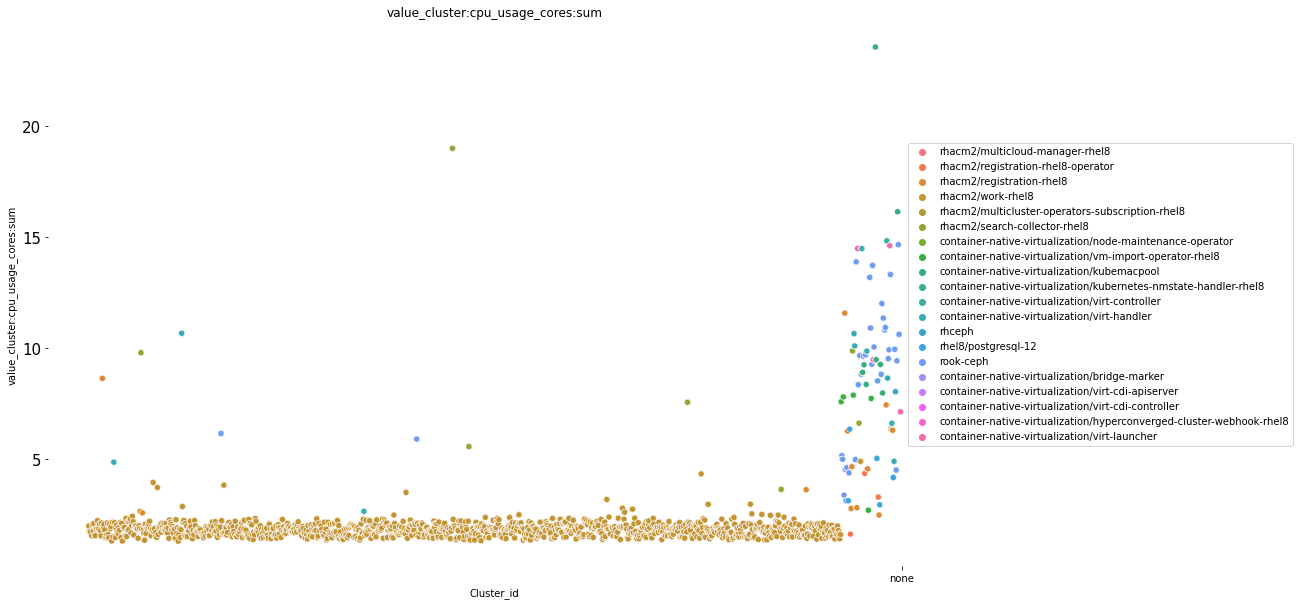

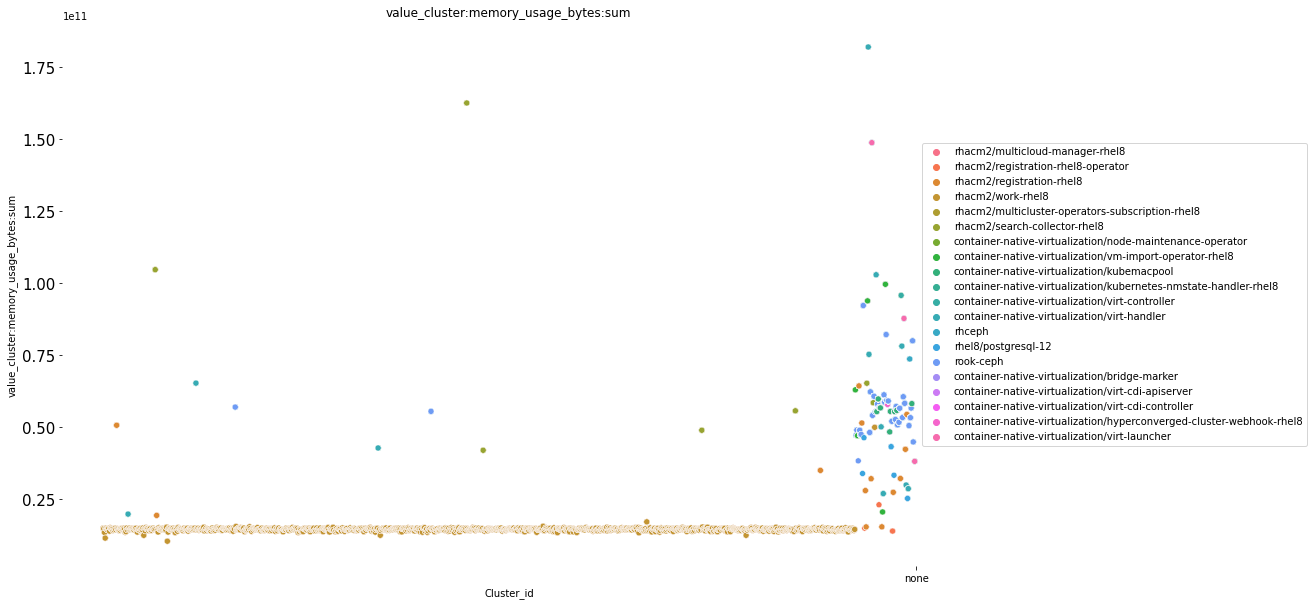

In [68]:
cont_value_columns = [
    "value_cluster:cpu_usage_cores:sum",
    "value_cluster:memory_usage_bytes:sum",
]

for col in cont_value_columns:
    fig, ax = plt.subplots(1, 1, figsize=(16, 10))
    g = sns.scatterplot(
        x=new_cont_nos_tele["cluster_id"],
        y=new_cont_nos_tele[col],
        data=new_cont_nos_tele,
        hue=new_cont_nos_tele["name"],
        legend=True,
    )
    g.legend(loc="right", bbox_to_anchor=(1.40, 0.5), ncol=1)
    plt.title(col)
    plt.xlabel("Cluster_id")
    plt.ylabel(col)
    plt.xticks("none")
    plt.yticks(fontsize=15)
    plt.box(False)

In [69]:
d1 = (
    new_cont_nos_tele.groupby("name")["value_workload:cpu_usage_cores:sum"]
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)
d2 = (
    new_cont_nos_tele.groupby("name")["value_workload:memory_usage_bytes:sum"]
    .mean()
    .sort_values(ascending=False)
    .to_frame()
)

dmerge = pd.merge(d1, d2, on="name", how="right")
dmerge

,value_workload:cpu_usage_cores:sum,value_workload:memory_usage_bytes:sum
name,,
rhacm2/multicluster-operators-subscription-rhel8,0.520397,5.748097e+09
rhacm2/search-collector-rhel8,0.419703,4.598778e+09
container-native-virtualization/virt-launcher,1.260865,2.948246e+09
container-native-virtualization/virt-controller,0.712677,2.033478e+09
container-native-virtualization/kubemacpool,0.706172,1.757727e+09
container-native-virtualization/node-maintenance-operator,0.692264,1.671478e+09
container-native-virtualization/kubernetes-nmstate-handler-rhel8,0.626914,1.482986e+09
container-native-virtualization/virt-handler,0.699701,1.413989e+09
container-native-virtualization/virt-cdi-controller,0.683963,1.155888e+09


The above table gives us a estimation of the cpu_usage and memory_usage values corresponding to the image_repos name from the workload containers dataset.

## Conclusion

The notebook provides the EDA results for the insight operator workload dataset which was merged with data from the Pyxis and telemetry dataset respectively. We do found some list of top image_ids/product name in the dataset and also plot the values obtained from the telemetry dataset with respect to cluster_ids.

Our next approach is to apply some ML clustering techniques in order to get some insight into group of workloads in the dataset. 

---